## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


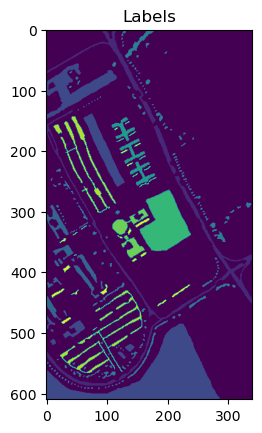

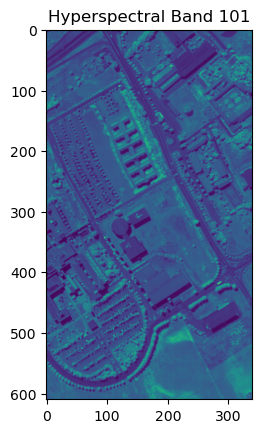

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 10 train


All datasets saved to the 'indices' folder.
(90, 5, 5, 103)
(45, 5, 5, 103)
(42641, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1261, PSNR: 7.1926


	 Training Batch [200/535], Loss: 0.0662, PSNR: 9.7921


	 Training Batch [400/535], Loss: 0.0333, PSNR: 12.9474


Epoch [1/50] Training Loss: 0.0576, PSNR: 11.0367
	[Val]   Batch [1/134] Loss: 0.0195, PSNR: 15.2894
	[Val]   Batch [10/134] Loss: 0.0172, PSNR: 17.6405
	[Val]   Batch [20/134] Loss: 0.0185, PSNR: 15.4444
	[Val]   Batch [30/134] Loss: 0.0200, PSNR: 14.9135
	[Val]   Batch [40/134] Loss: 0.0182, PSNR: 13.9520
	[Val]   Batch [50/134] Loss: 0.0193, PSNR: 15.1073
	[Val]   Batch [60/134] Loss: 0.0175, PSNR: 15.7682
	[Val]   Batch [70/134] Loss: 0.0167, PSNR: 15.9493


	[Val]   Batch [80/134] Loss: 0.0163, PSNR: 15.9396
	[Val]   Batch [90/134] Loss: 0.0172, PSNR: 15.9265
	[Val]   Batch [100/134] Loss: 0.0193, PSNR: 15.3518
	[Val]   Batch [110/134] Loss: 0.0196, PSNR: 13.8854
	[Val]   Batch [120/134] Loss: 0.0161, PSNR: 15.0216
	[Val]   Batch [130/134] Loss: 0.0178, PSNR: 13.0550
Epoch [1/50] Validation Loss: 0.0185, PSNR: 15.3064

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0186, PSNR: 15.5270


	 Training Batch [200/535], Loss: 0.0136, PSNR: 16.8628


	 Training Batch [400/535], Loss: 0.0093, PSNR: 18.5199


Epoch [2/50] Training Loss: 0.0120, PSNR: 17.2835
	[Val]   Batch [1/134] Loss: 0.0089, PSNR: 18.7135
	[Val]   Batch [10/134] Loss: 0.0072, PSNR: 21.4477
	[Val]   Batch [20/134] Loss: 0.0078, PSNR: 19.1996
	[Val]   Batch [30/134] Loss: 0.0088, PSNR: 18.4794
	[Val]   Batch [40/134] Loss: 0.0079, PSNR: 17.5732
	[Val]   Batch [50/134] Loss: 0.0082, PSNR: 18.8220
	[Val]   Batch [60/134] Loss: 0.0072, PSNR: 19.6219


	[Val]   Batch [70/134] Loss: 0.0070, PSNR: 19.7039
	[Val]   Batch [80/134] Loss: 0.0067, PSNR: 19.7896
	[Val]   Batch [90/134] Loss: 0.0071, PSNR: 19.7338
	[Val]   Batch [100/134] Loss: 0.0085, PSNR: 18.9196
	[Val]   Batch [110/134] Loss: 0.0080, PSNR: 17.7563
	[Val]   Batch [120/134] Loss: 0.0061, PSNR: 19.2752
	[Val]   Batch [130/134] Loss: 0.0072, PSNR: 16.9559
Epoch [2/50] Validation Loss: 0.0080, PSNR: 18.9439

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0084, PSNR: 19.8907


	 Training Batch [200/535], Loss: 0.0063, PSNR: 20.1814


	 Training Batch [400/535], Loss: 0.0066, PSNR: 19.9050


Epoch [3/50] Training Loss: 0.0070, PSNR: 19.5457
	[Val]   Batch [1/134] Loss: 0.0062, PSNR: 20.2648
	[Val]   Batch [10/134] Loss: 0.0049, PSNR: 23.0606
	[Val]   Batch [20/134] Loss: 0.0053, PSNR: 20.8807
	[Val]   Batch [30/134] Loss: 0.0060, PSNR: 20.1720
	[Val]   Batch [40/134] Loss: 0.0055, PSNR: 19.1773
	[Val]   Batch [50/134] Loss: 0.0055, PSNR: 20.5351
	[Val]   Batch [60/134] Loss: 0.0049, PSNR: 21.3093


	[Val]   Batch [70/134] Loss: 0.0048, PSNR: 21.3420
	[Val]   Batch [80/134] Loss: 0.0046, PSNR: 21.4646
	[Val]   Batch [90/134] Loss: 0.0049, PSNR: 21.3837
	[Val]   Batch [100/134] Loss: 0.0059, PSNR: 20.5222
	[Val]   Batch [110/134] Loss: 0.0053, PSNR: 19.5756
	[Val]   Batch [120/134] Loss: 0.0038, PSNR: 21.2447
	[Val]   Batch [130/134] Loss: 0.0048, PSNR: 18.7341
Epoch [3/50] Validation Loss: 0.0056, PSNR: 20.5566

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0052, PSNR: 20.9108


	 Training Batch [200/535], Loss: 0.0062, PSNR: 20.2859


	 Training Batch [400/535], Loss: 0.0046, PSNR: 21.3847


Epoch [4/50] Training Loss: 0.0050, PSNR: 21.0270
	[Val]   Batch [1/134] Loss: 0.0042, PSNR: 21.9909
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.7243
	[Val]   Batch [20/134] Loss: 0.0034, PSNR: 22.7676
	[Val]   Batch [30/134] Loss: 0.0038, PSNR: 22.1025
	[Val]   Batch [40/134] Loss: 0.0035, PSNR: 21.0811
	[Val]   Batch [50/134] Loss: 0.0035, PSNR: 22.5872
	[Val]   Batch [60/134] Loss: 0.0034, PSNR: 22.8816


	[Val]   Batch [70/134] Loss: 0.0033, PSNR: 22.9980
	[Val]   Batch [80/134] Loss: 0.0031, PSNR: 23.1631
	[Val]   Batch [90/134] Loss: 0.0033, PSNR: 23.1000
	[Val]   Batch [100/134] Loss: 0.0039, PSNR: 22.2850
	[Val]   Batch [110/134] Loss: 0.0033, PSNR: 21.6373
	[Val]   Batch [120/134] Loss: 0.0025, PSNR: 23.1590
	[Val]   Batch [130/134] Loss: 0.0030, PSNR: 20.7285
Epoch [4/50] Validation Loss: 0.0037, PSNR: 22.3095

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0043, PSNR: 23.6653


	 Training Batch [200/535], Loss: 0.0043, PSNR: 22.7476


	 Training Batch [400/535], Loss: 0.0033, PSNR: 22.9741


Epoch [5/50] Training Loss: 0.0036, PSNR: 22.5220
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.2921
	[Val]   Batch [10/134] Loss: 0.0025, PSNR: 26.0486
	[Val]   Batch [20/134] Loss: 0.0024, PSNR: 24.3284
	[Val]   Batch [30/134] Loss: 0.0027, PSNR: 23.6428
	[Val]   Batch [40/134] Loss: 0.0025, PSNR: 22.6399
	[Val]   Batch [50/134] Loss: 0.0024, PSNR: 24.2311
	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.0456


	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.2618
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.4289
	[Val]   Batch [90/134] Loss: 0.0025, PSNR: 24.3691
	[Val]   Batch [100/134] Loss: 0.0028, PSNR: 23.6933
	[Val]   Batch [110/134] Loss: 0.0022, PSNR: 23.4173
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.7067
	[Val]   Batch [130/134] Loss: 0.0021, PSNR: 22.2739
Epoch [5/50] Validation Loss: 0.0027, PSNR: 23.6847

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0025, PSNR: 24.0579


	 Training Batch [200/535], Loss: 0.0030, PSNR: 23.3595


	 Training Batch [400/535], Loss: 0.0031, PSNR: 23.2112


Epoch [6/50] Training Loss: 0.0028, PSNR: 23.4826
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.0615
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.8864
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.3544
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.5880
	[Val]   Batch [40/134] Loss: 0.0019, PSNR: 23.6518
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.2342
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.8353


	[Val]   Batch [70/134] Loss: 0.0020, PSNR: 25.0928
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.2881
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 25.1406
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.5824
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.5162
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.7641
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.2269
Epoch [6/50] Validation Loss: 0.0022, PSNR: 24.5615

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0025, PSNR: 24.1824


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.4120


	 Training Batch [400/535], Loss: 0.0019, PSNR: 23.3985


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.1252
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.5968
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.4512
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.1356
	[Val]   Batch [30/134] Loss: 0.0018, PSNR: 25.2732
	[Val]   Batch [40/134] Loss: 0.0016, PSNR: 24.3966
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.9301
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.3829


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6559
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.8873
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.6781
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.1978
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.3281
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5412
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.9242
Epoch [7/50] Validation Loss: 0.0019, PSNR: 25.1960

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0024, PSNR: 24.5362


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.7130


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.2019


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.6231
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 25.0301
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.9277
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.7743
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 25.8309
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 25.0383
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.5460
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.8309


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.1266
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3924
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.1401
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.7386
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 26.0372
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.2065
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.4987
Epoch [8/50] Validation Loss: 0.0017, PSNR: 25.7288

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 24.9123


	 Training Batch [200/535], Loss: 0.0024, PSNR: 24.2517


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.2501


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.8723
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.3398
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.2435
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.2332
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.2301
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.5000
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.9299
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.1738


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4547
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.7493
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.4576
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1108
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.5257
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.6588
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.8961
Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.1036

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.4013


	 Training Batch [200/535], Loss: 0.0016, PSNR: 24.2540


	 Training Batch [400/535], Loss: 0.0034, PSNR: 22.8399


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.1952
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.5472
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4314
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.5341
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.4724
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.7620
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1645


	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.3951
	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6563
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9974
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.6849
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.3483
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.7867


	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.9203
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.1382
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.3461

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.2707


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.6061


	 Training Batch [400/535], Loss: 0.0014, PSNR: 24.8034


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.4072
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.7753
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6894
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.8852
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.7748
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.0930
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4629
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6580


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9098
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2916
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.9522
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6233
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.1490
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2784
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.4688
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.6350

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.3980


	 Training Batch [200/535], Loss: 0.0013, PSNR: 25.6612


	 Training Batch [400/535], Loss: 0.0022, PSNR: 26.1312


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.5919
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9068
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8054
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.0517
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.9181
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.2280
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.5696
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.8174


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.0404
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.4487
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1001
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.7493
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.2920
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.4116
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5955
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.7778

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0026, PSNR: 24.0756


	 Training Batch [200/535], Loss: 0.0016, PSNR: 25.8150


	 Training Batch [400/535], Loss: 0.0017, PSNR: 27.8062


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.7905
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0530
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9609
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.2772
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0875
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4518
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.7570


	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9925
	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.2067
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6425
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2712
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9322
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.4593


	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6246
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.8000
Epoch [13/50] Validation Loss: 0.0013, PSNR: 26.9604

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 25.6866


	 Training Batch [200/535], Loss: 0.0011, PSNR: 25.9979


	 Training Batch [400/535], Loss: 0.0018, PSNR: 27.4103


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9365
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.2960
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2292
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6369
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.3989
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.7848
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1028
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.2535


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4682
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9350
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5477
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.2291
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.8989
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.9476
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1289
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.2633

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.3800


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.4564


	 Training Batch [400/535], Loss: 0.0011, PSNR: 25.7138


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1302
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4441
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4123
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8921
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6002
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0105
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2618
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5140


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.6985
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.1815
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7380
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4160
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.0925
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2382
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3646
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.4717

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.5855


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.1293


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.0180


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2232
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6193
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5292
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0745
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7459
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1646
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4194
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6799


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8581
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3402
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9060
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5585
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2390
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4016
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5318
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6270

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 25.0143


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.8366


	 Training Batch [400/535], Loss: 0.0010, PSNR: 26.3086


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.3827
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8559
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7400
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4440
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0361
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4434
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.6924
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.9497


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1262
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6078
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1716
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8397
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5407
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6506
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7969
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.8918

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.6267


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.8764


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.3417


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.5068
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0069
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8472
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.6157
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.2222
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.6038
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.8714
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1339


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2996
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.7510
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.3117
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0310
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.6753
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6891
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.9250
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.0417

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 27.9931


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.3969


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.0944


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.7001
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2357
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0237
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.9333
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4652
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8643
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0911


	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4393
	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.6336
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9754
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.5809
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2998
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8323
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9313
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1986
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.2867

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.7132


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.5163


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.4620


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.9329
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.4949
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2238
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.2403
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.7827
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.1478
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4040
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.7796


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 28.9607
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2356
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.8615
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.6053
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0196
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0710


	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.4536
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.5486

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.9837


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.4123


	 Training Batch [400/535], Loss: 0.0021, PSNR: 26.2773


Epoch [21/50] Training Loss: 0.0013, PSNR: 27.0874
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.7919
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4508
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.6016
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.1428
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.4083
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6895
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.1122


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3525
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.5096
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.2144
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 28.9684
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1971
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2287
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7415
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.8421

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.2063


	 Training Batch [200/535], Loss: 0.0017, PSNR: 26.0520


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9238


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.2592
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.1066
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6806
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.9157
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.5312
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.7199
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.0199
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.4711


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7397
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.8358
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.5776
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.3401
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4611
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4179
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0585
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.1569

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0007, PSNR: 27.4359


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.7336


	 Training Batch [400/535], Loss: 0.0009, PSNR: 26.8666


Epoch [23/50] Training Loss: 0.0012, PSNR: 27.4648
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.3943
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.9017
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.1857
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.8339
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9268
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.2871
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.7555


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 30.0429
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0404
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.8744
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.6316
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.5470
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.5531
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2419
Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.4146

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.2581


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.2453


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.0983


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.6177
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.6764
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.1242
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3795
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.1218
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.1544
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.5328
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9837


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.3380
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.3262
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.1614
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.9326
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7330
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6690
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4373
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.6742

LOG: Epoch [25/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 29.8716


	 Training Batch [200/535], Loss: 0.0009, PSNR: 26.6239


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4687


Epoch [25/50] Training Loss: 0.0011, PSNR: 27.8669
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8546
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.2421
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.4439
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.2507
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.1831
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.6178
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.0825


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4504
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.3807
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.3355
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0706
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6802
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6582
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4411


Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.7776

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 28.7927


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.2763


	 Training Batch [400/535], Loss: 0.0007, PSNR: 27.8039


Epoch [26/50] Training Loss: 0.0010, PSNR: 27.9758
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.1323
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.5060
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6777
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.6187
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4225
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.9456


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3151
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7389
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6553
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.6194
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3710
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9122
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8087
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6967


Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.0618

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 28.9675


	 Training Batch [200/535], Loss: 0.0009, PSNR: 27.6435


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.6320


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.1405
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3964
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6893
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.0148
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.8673
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6314
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.2303
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5419


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.9913
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8704
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 30.8829
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.6289
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1347
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9786
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9096
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.3104

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8475


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.4011


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.7808


Epoch [28/50] Training Loss: 0.0010, PSNR: 28.2201
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.6103
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.8444
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1784
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.1370
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.7391
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.3901
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.6782


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1324
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0282
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.0755
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.8370
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1949
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0348
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 29.0093
Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.4813

LOG: Epoch [29/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 29.0647


	 Training Batch [200/535], Loss: 0.0007, PSNR: 29.6169


	 Training Batch [400/535], Loss: 0.0007, PSNR: 29.4385


Epoch [29/50] Training Loss: 0.0009, PSNR: 28.3934
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.7255
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.9616
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1396
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.1732
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.8582
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.4855
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7234


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.2970
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.1197
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.2082
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.9341
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.2681
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.1107
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1261
Epoch [29/50] Validation Loss: 0.0006, PSNR: 30.5991

LOG: Epoch [30/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 29.2282


	 Training Batch [200/535], Loss: 0.0007, PSNR: 27.5933


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.4264


Epoch [30/50] Training Loss: 0.0009, PSNR: 28.4842
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.9783
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 32.0714
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.2637
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.3856
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9188
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.5951
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.9003


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.4136
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.2488
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.3573
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 31.0920
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3493
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.2496
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1555
Epoch [30/50] Validation Loss: 0.0005, PSNR: 30.7444

LOG: Epoch [31/50]


	 Training Batch [1/535], Loss: 0.0007, PSNR: 29.5991


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.1976


	 Training Batch [400/535], Loss: 0.0007, PSNR: 27.8522


Epoch [31/50] Training Loss: 0.0009, PSNR: 28.6104
	[Val]   Batch [1/134] Loss: 0.0006, PSNR: 30.1816
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 32.2849
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.6170
	[Val]   Batch [30/134] Loss: 0.0004, PSNR: 31.6744
	[Val]   Batch [40/134] Loss: 0.0004, PSNR: 30.1835
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.8773
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 31.0847


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.6162
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.4599
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.6166
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 31.3772
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.6166
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.3696
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.4387
Epoch [31/50] Validation Loss: 0.0005, PSNR: 31.0034
Early stopping triggered at epoch 31. No improvement for 3 epochs.


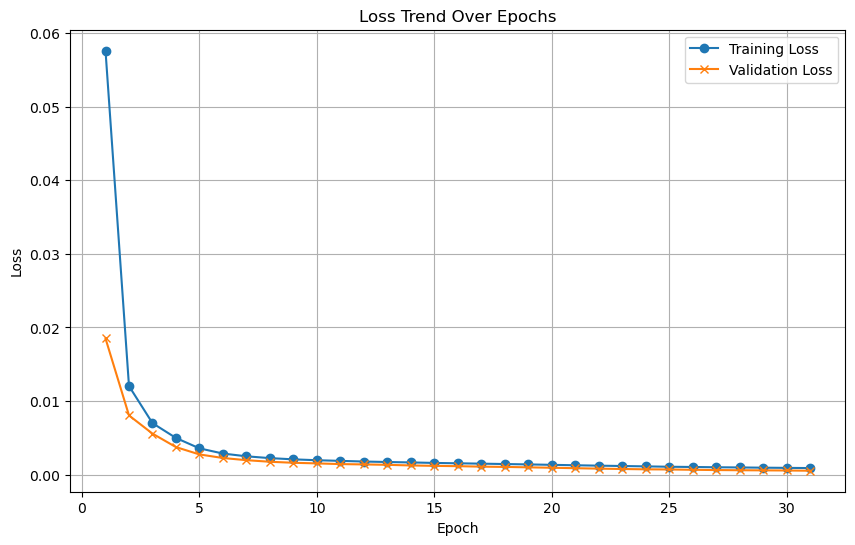

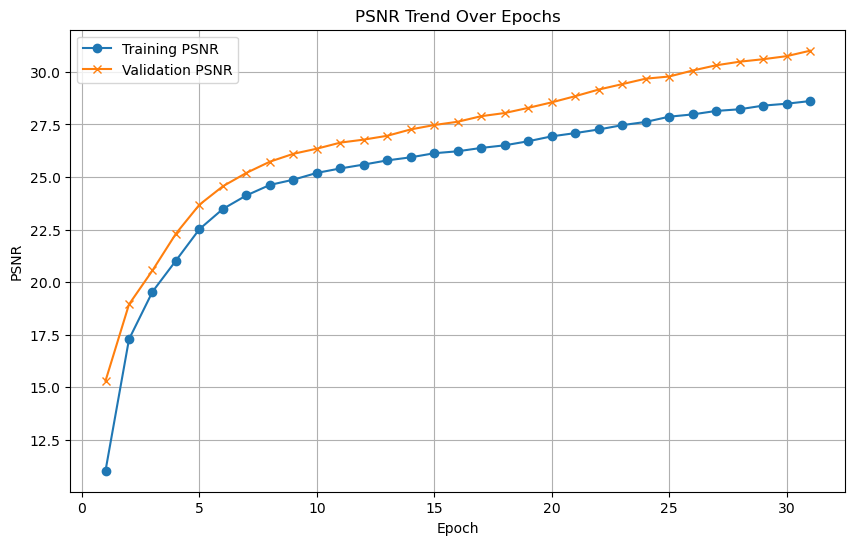

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1947
    Validation Batch [1/1], Loss: 2.2041
Validation Loss: 2.2041, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2041. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1503
    Validation Batch [1/1], Loss: 2.2041
Validation Loss: 2.2041, Validation Accuracy: 11.11%
Validation loss improved from 2.2041 to 2.2041. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1235
    Validation Batch [1/1], Loss: 2.2041
Validation Loss: 2.2041, Validation Accuracy: 11.11%
Validation loss improved from 2.2041 to 2.2041. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0918
    Validation Batch [1/1], Loss: 2.2040
Validation Loss: 2.2040, Validation Accuracy: 11.11%
Validation loss improved from 2.2041 to 2.2040. Saving model...

LOG: Epoch [5/1000

Epoch [21/1000] completed, Average Training Loss: 1.8689
    Validation Batch [1/1], Loss: 2.2031
Validation Loss: 2.2031, Validation Accuracy: 11.11%
Validation loss improved from 2.2033 to 2.2031. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.8739
    Validation Batch [1/1], Loss: 2.2027
Validation Loss: 2.2027, Validation Accuracy: 11.11%
Validation loss improved from 2.2031 to 2.2027. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.8532
    Validation Batch [1/1], Loss: 2.2022
Validation Loss: 2.2022, Validation Accuracy: 11.11%
Validation loss improved from 2.2027 to 2.2022. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.8458
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss improved from 2.2022 to 2.2015. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [2

Epoch [54/1000] completed, Average Training Loss: 1.6671
    Validation Batch [1/1], Loss: 1.9074
Validation Loss: 1.9074, Validation Accuracy: 68.89%
Validation loss improved from 1.9229 to 1.9074. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.6278
    Validation Batch [1/1], Loss: 1.8934
Validation Loss: 1.8934, Validation Accuracy: 68.89%
Validation loss improved from 1.9074 to 1.8934. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.6440
    Validation Batch [1/1], Loss: 1.8800
Validation Loss: 1.8800, Validation Accuracy: 68.89%
Validation loss improved from 1.8934 to 1.8800. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.6098
    Validation Batch [1/1], Loss: 1.8674
Validation Loss: 1.8674, Validation Accuracy: 68.89%
Validation loss improved from 1.8800 to 1.8674. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [5

Epoch [85/1000] completed, Average Training Loss: 1.4316
    Validation Batch [1/1], Loss: 1.6558
Validation Loss: 1.6558, Validation Accuracy: 71.11%
Validation loss improved from 1.6581 to 1.6558. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.4084
    Validation Batch [1/1], Loss: 1.6512
Validation Loss: 1.6512, Validation Accuracy: 71.11%
Validation loss improved from 1.6558 to 1.6512. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.4293
    Validation Batch [1/1], Loss: 1.6442
Validation Loss: 1.6442, Validation Accuracy: 71.11%
Validation loss improved from 1.6512 to 1.6442. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.3872
    Validation Batch [1/1], Loss: 1.6387
Validation Loss: 1.6387, Validation Accuracy: 71.11%
Validation loss improved from 1.6442 to 1.6387. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [8

Epoch [112/1000] completed, Average Training Loss: 1.2316
    Validation Batch [1/1], Loss: 1.5224
Validation Loss: 1.5224, Validation Accuracy: 68.89%
Validation loss improved from 1.5280 to 1.5224. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.2192
    Validation Batch [1/1], Loss: 1.5194
Validation Loss: 1.5194, Validation Accuracy: 68.89%
Validation loss improved from 1.5224 to 1.5194. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.1844
    Validation Batch [1/1], Loss: 1.5161
Validation Loss: 1.5161, Validation Accuracy: 68.89%
Validation loss improved from 1.5194 to 1.5161. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.2083
    Validation Batch [1/1], Loss: 1.5075
Validation Loss: 1.5075, Validation Accuracy: 71.11%
Validation loss improved from 1.5161 to 1.5075. Saving model...

LOG: Epoch [116/1000] - Training


Epoch [143/1000] completed, Average Training Loss: 0.9547
    Validation Batch [1/1], Loss: 1.4016
Validation Loss: 1.4016, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 0.9905
    Validation Batch [1/1], Loss: 1.3906
Validation Loss: 1.3906, Validation Accuracy: 71.11%
Validation loss improved from 1.4003 to 1.3906. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 0.9653
    Validation Batch [1/1], Loss: 1.3727
Validation Loss: 1.3727, Validation Accuracy: 71.11%
Validation loss improved from 1.3906 to 1.3727. Saving model...

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 0.9738
    Validation Batch [1/1], Loss: 1.3617
Validation Loss: 1.3617, Validation Accuracy: 68.89%
Validation loss improved from 1.3727 to 1.3617. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000

Validation Loss: 1.2473, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.7703
    Validation Batch [1/1], Loss: 1.2544
Validation Loss: 1.2544, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.7629
    Validation Batch [1/1], Loss: 1.2485
Validation Loss: 1.2485, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.7227
    Validation Batch [1/1], Loss: 1.2341
Validation Loss: 1.2341, Validation Accuracy: 77.78%
Validation loss improved from 1.2435 to 1.2341. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 0.7814
    Validation Batch [1/1], Loss: 1.2246
Validation Loss: 1.2246, Validation Accuracy:

Epoch [212/1000] completed, Average Training Loss: 0.5622
    Validation Batch [1/1], Loss: 1.1165
Validation Loss: 1.1165, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.5854
    Validation Batch [1/1], Loss: 1.1166
Validation Loss: 1.1166, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.6017
    Validation Batch [1/1], Loss: 1.1100
Validation Loss: 1.1100, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.5688
    Validation Batch [1/1], Loss: 1.0888
Validation Loss: 1.0888, Validation Accuracy: 82.22%
Validation loss improved from 1.0973 to 1.0888. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training 

Epoch [244/1000] completed, Average Training Loss: 0.4178
    Validation Batch [1/1], Loss: 0.9840
Validation Loss: 0.9840, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.3830
    Validation Batch [1/1], Loss: 0.9868
Validation Loss: 0.9868, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.3981
    Validation Batch [1/1], Loss: 0.9437
Validation Loss: 0.9437, Validation Accuracy: 80.00%
Validation loss improved from 0.9538 to 0.9437. Saving model...

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.4360
    Validation Batch [1/1], Loss: 0.9044
Validation Loss: 0.9044, Validation Accuracy: 77.78%
Validation loss improved from 0.9437 to 0.9044. Saving model...

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Av

Epoch [276/1000] completed, Average Training Loss: 0.2825
    Validation Batch [1/1], Loss: 0.8617
Validation Loss: 0.8617, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.3044
    Validation Batch [1/1], Loss: 0.8438
Validation Loss: 0.8438, Validation Accuracy: 82.22%
Validation loss improved from 0.8550 to 0.8438. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.2618
    Validation Batch [1/1], Loss: 0.8256
Validation Loss: 0.8256, Validation Accuracy: 84.44%
Validation loss improved from 0.8438 to 0.8256. Saving model...

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.3053
    Validation Batch [1/1], Loss: 0.8358
Validation Loss: 0.8358, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Av

Epoch [307/1000] completed, Average Training Loss: 0.2528
    Validation Batch [1/1], Loss: 0.7540
Validation Loss: 0.7540, Validation Accuracy: 82.22%
Validation loss improved from 0.7685 to 0.7540. Saving model...

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.2043
    Validation Batch [1/1], Loss: 0.7586
Validation Loss: 0.7586, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.1998
    Validation Batch [1/1], Loss: 0.7590
Validation Loss: 0.7590, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.1971
    Validation Batch [1/1], Loss: 0.7599
Validation Loss: 0.7599, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training 

Epoch [339/1000] completed, Average Training Loss: 0.1511
    Validation Batch [1/1], Loss: 0.7296
Validation Loss: 0.7296, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.1612
    Validation Batch [1/1], Loss: 0.7213
Validation Loss: 0.7213, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.1541
    Validation Batch [1/1], Loss: 0.7165
Validation Loss: 0.7165, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.1348
    Validation Batch [1/1], Loss: 0.7288
Validation Loss: 0.7288, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.1438
  

    Validation Batch [1/1], Loss: 0.7367
Validation Loss: 0.7367, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.1269
    Validation Batch [1/1], Loss: 0.7273
Validation Loss: 0.7273, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.0986
    Validation Batch [1/1], Loss: 0.7094
Validation Loss: 0.7094, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.1338
    Validation Batch [1/1], Loss: 0.6927
Validation Loss: 0.6927, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.1221
    Validation Batch [1/1], Loss: 0.6924
Validation Loss

    Validation Batch [1/1], Loss: 0.6443
Validation Loss: 0.6443, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1204
    Validation Batch [1/1], Loss: 0.6565
Validation Loss: 0.6565, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0981
    Validation Batch [1/1], Loss: 0.6811
Validation Loss: 0.6811, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0771
    Validation Batch [1/1], Loss: 0.6655
Validation Loss: 0.6655, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.1084
    Validation Batch [1/1], Loss: 0.6691
Validation Loss: 0.

Epoch [432/1000] completed, Average Training Loss: 0.0812
    Validation Batch [1/1], Loss: 0.6816
Validation Loss: 0.6816, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0734
    Validation Batch [1/1], Loss: 0.6712
Validation Loss: 0.6712, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0870
    Validation Batch [1/1], Loss: 0.6748
Validation Loss: 0.6748, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.0715
    Validation Batch [1/1], Loss: 0.7025
Validation Loss: 0.7025, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.090

Epoch [465/1000] completed, Average Training Loss: 0.0677
    Validation Batch [1/1], Loss: 0.7076
Validation Loss: 0.7076, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0686
    Validation Batch [1/1], Loss: 0.7343
Validation Loss: 0.7343, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0540
    Validation Batch [1/1], Loss: 0.7161
Validation Loss: 0.7161, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0530
    Validation Batch [1/1], Loss: 0.6749
Validation Loss: 0.6749, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.055

Epoch [499/1000] completed, Average Training Loss: 0.0617
    Validation Batch [1/1], Loss: 0.5991
Validation Loss: 0.5991, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.6090
Validation Loss: 0.6090, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0365
    Validation Batch [1/1], Loss: 0.6289
Validation Loss: 0.6289, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.6517
Validation Loss: 0.6517, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0519


Epoch [530/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.7177
Validation Loss: 0.7177, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.7684
Validation Loss: 0.7684, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0394
    Validation Batch [1/1], Loss: 0.7598
Validation Loss: 0.7598, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0516
    Validation Batch [1/1], Loss: 0.6642
Validation Loss: 0.6642, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.052

Epoch [563/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.6734
Validation Loss: 0.6734, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0275
    Validation Batch [1/1], Loss: 0.7052
Validation Loss: 0.7052, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.7385
Validation Loss: 0.7385, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.0330
    Validation Batch [1/1], Loss: 0.7511
Validation Loss: 0.7511, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.041

Validation Loss: 0.6437, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.6702
Validation Loss: 0.6702, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0292
    Validation Batch [1/1], Loss: 0.7068
Validation Loss: 0.7068, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.7389
Validation Loss: 0.7389, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.7620
Validation Loss: 0.7620, Validation Accuracy: 82.22%
Val

Epoch [627/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.6930
Validation Loss: 0.6930, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0340
    Validation Batch [1/1], Loss: 0.6827
Validation Loss: 0.6827, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.7016
Validation Loss: 0.7016, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.7233
Validation Loss: 0.7233, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [631/1000] - Training
Epoch [631/1000] completed, Average Training Loss: 0.017

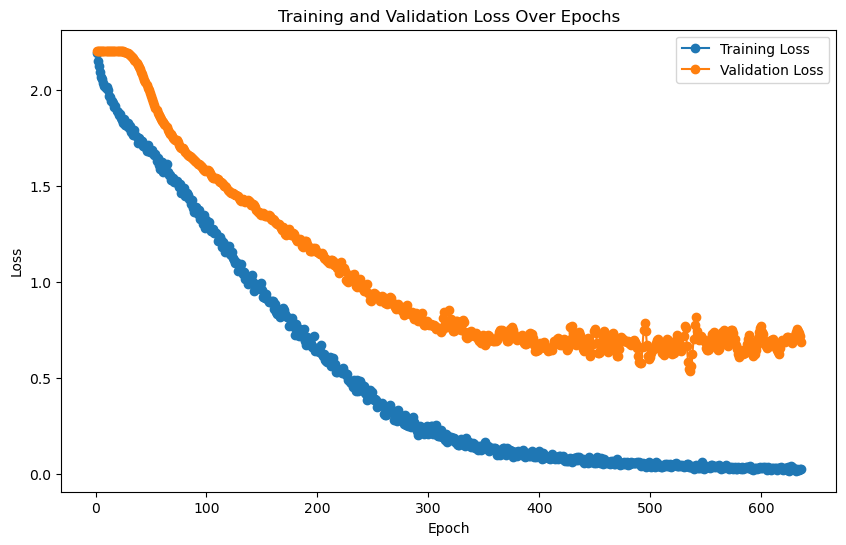

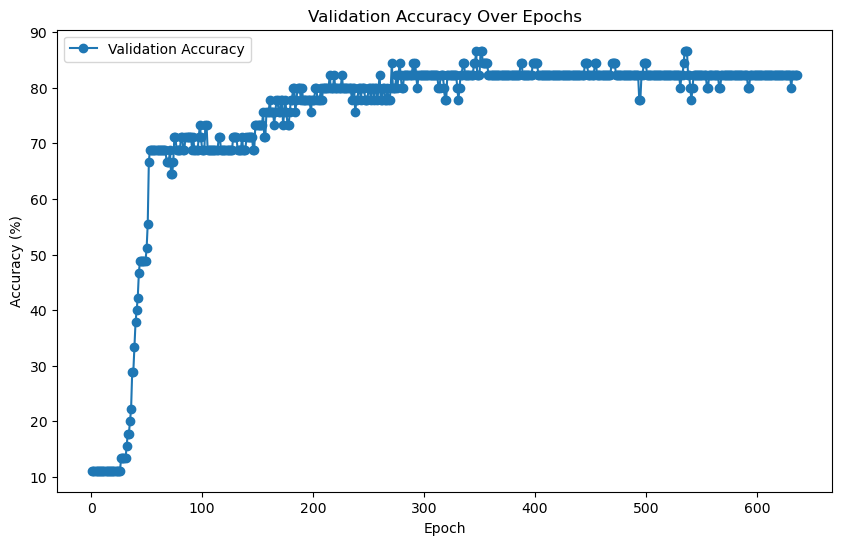


Evaluating on the test set...
    Test Batch [1/167], Loss: 1.4738



Final Test Loss: 1.0222, Test Accuracy: 72.31%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.


  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42641, 64), Test labels shape: (42641,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 66.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.60      0.60      0.60         5
           2       0.50      0.40      0.44         5
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5
           5       0.60      0.60      0.60         5
           6       0.45      1.00      0.62         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42641, 64)
Test labels shape: (42641,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3964  |  Val Loss: 2.1678
Validation loss improved from inf to 2.1678.
[Epoch 2/1000] Train Loss: 2.2016  |  Val Loss: 2.0906
Validation loss improved from 2.1678 to 2.0906.
[Epoch 3/1000] Train Loss: 2.0930  |  Val Loss: 2.0391
Validation loss improved from 2.0906 to 2.0391.
[Epoch 4/1000] Train Loss: 2.0239  |  Val Loss: 2.0012
Validation loss improved from 2.0391 to 2.0012.
[Epoch 5/1000] Train Loss: 1.9621  |  Val Loss: 1.9609
Validation loss improved from 2.0012 to 1.9609.
[Epoch 6/1000] Train Loss: 1.9038  |  Val Loss: 1.9106
Validation loss improved from 1.9609 to 1.9106.
[Epoch 7/1000] Train Loss: 1.8369  |  Val Loss: 1.8561
Validation loss improved from 1.9106 to 1.8561.
[Epoch 8/1000] Train Loss: 1.7703  |  Val Loss: 1.8028
Validation loss improved from 1.8561 to 1.8028.


[Epoch 9/1000] Train Loss: 1.7132  |  Val Loss: 1.7562
Validation loss improved from 1.8028 to 1.7562.
[Epoch 10/1000] Train Loss: 1.6555  |  Val Loss: 1.7134
Validation loss improved from 1.7562 to 1.7134.
[Epoch 11/1000] Train Loss: 1.6094  |  Val Loss: 1.6726
Validation loss improved from 1.7134 to 1.6726.
[Epoch 12/1000] Train Loss: 1.5648  |  Val Loss: 1.6334
Validation loss improved from 1.6726 to 1.6334.
[Epoch 13/1000] Train Loss: 1.5215  |  Val Loss: 1.5933
Validation loss improved from 1.6334 to 1.5933.
[Epoch 14/1000] Train Loss: 1.4724  |  Val Loss: 1.5552
Validation loss improved from 1.5933 to 1.5552.
[Epoch 15/1000] Train Loss: 1.4243  |  Val Loss: 1.5203
Validation loss improved from 1.5552 to 1.5203.
[Epoch 16/1000] Train Loss: 1.3842  |  Val Loss: 1.4858
Validation loss improved from 1.5203 to 1.4858.
[Epoch 17/1000] Train Loss: 1.3437  |  Val Loss: 1.4523
Validation loss improved from 1.4858 to 1.4523.
[Epoch 18/1000] Train Loss: 1.3045  |  Val Loss: 1.4158
Validatio

[Epoch 31/1000] Train Loss: 0.8162  |  Val Loss: 0.9924
Validation loss improved from 1.0107 to 0.9924.
[Epoch 32/1000] Train Loss: 0.7870  |  Val Loss: 0.9744
Validation loss improved from 0.9924 to 0.9744.
[Epoch 33/1000] Train Loss: 0.7635  |  Val Loss: 0.9509
Validation loss improved from 0.9744 to 0.9509.
[Epoch 34/1000] Train Loss: 0.7311  |  Val Loss: 0.9280
Validation loss improved from 0.9509 to 0.9280.
[Epoch 35/1000] Train Loss: 0.7041  |  Val Loss: 0.9086
Validation loss improved from 0.9280 to 0.9086.
[Epoch 36/1000] Train Loss: 0.6815  |  Val Loss: 0.8872
Validation loss improved from 0.9086 to 0.8872.
[Epoch 37/1000] Train Loss: 0.6588  |  Val Loss: 0.8652
Validation loss improved from 0.8872 to 0.8652.
[Epoch 38/1000] Train Loss: 0.6334  |  Val Loss: 0.8469
Validation loss improved from 0.8652 to 0.8469.
[Epoch 39/1000] Train Loss: 0.6134  |  Val Loss: 0.8365
Validation loss improved from 0.8469 to 0.8365.
[Epoch 40/1000] Train Loss: 0.5958  |  Val Loss: 0.8229
Validati

[Epoch 48/1000] Train Loss: 0.4647  |  Val Loss: 0.7210
Validation loss improved from 0.7277 to 0.7210.
[Epoch 49/1000] Train Loss: 0.4540  |  Val Loss: 0.7049
Validation loss improved from 0.7210 to 0.7049.
[Epoch 50/1000] Train Loss: 0.4431  |  Val Loss: 0.6915
Validation loss improved from 0.7049 to 0.6915.
[Epoch 51/1000] Train Loss: 0.4326  |  Val Loss: 0.6822
Validation loss improved from 0.6915 to 0.6822.
[Epoch 52/1000] Train Loss: 0.4203  |  Val Loss: 0.6827
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 0.4127  |  Val Loss: 0.6930
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 54/1000] Train Loss: 0.4061  |  Val Loss: 0.7001
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 55/1000] Train Loss: 0.3983  |  Val Loss: 0.7013
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 56/1000] Train Loss: 0.3939  |  Val Loss: 0.6867
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 57/1000] Train Loss: 0.3776

[Epoch 77/1000] Train Loss: 0.2744  |  Val Loss: 0.6631
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] Train Loss: 0.2763  |  Val Loss: 0.6684
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 79/1000] Train Loss: 0.2651  |  Val Loss: 0.6920
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 80/1000] Train Loss: 0.2638  |  Val Loss: 0.7132
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 81/1000] Train Loss: 0.2651  |  Val Loss: 0.6926
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 82/1000] Train Loss: 0.2505  |  Val Loss: 0.6794
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 83/1000] Train Loss: 0.2587  |  Val Loss: 0.6747
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 84/1000] Train Loss: 0.2558  |  Val Loss: 0.6679
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 85/1000] Train Loss: 0.2449  |  Val Loss: 0.6760
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 86/

[Epoch 97/1000] Train Loss: 0.2056  |  Val Loss: 0.7580
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 98/1000] Train Loss: 0.2156  |  Val Loss: 0.7726
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 99/1000] Train Loss: 0.2198  |  Val Loss: 0.7338
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 100/1000] Train Loss: 0.2137  |  Val Loss: 0.7009
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 101/1000] Train Loss: 0.2007  |  Val Loss: 0.6979
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 102/1000] Train Loss: 0.2013  |  Val Loss: 0.7255
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 103/1000] Train Loss: 0.2041  |  Val Loss: 0.7372
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 104/1000] Train Loss: 0.2004  |  Val Loss: 0.7320
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 105/1000] Train Loss: 0.1957  |  Val Loss: 0.7092
!! Validation loss did NOT improve !! Patience: 29

[Epoch 119/1000] Train Loss: 0.1627  |  Val Loss: 0.7686
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 120/1000] Train Loss: 0.1594  |  Val Loss: 0.7851
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 121/1000] Train Loss: 0.1577  |  Val Loss: 0.7891
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 122/1000] Train Loss: 0.1547  |  Val Loss: 0.7730
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 123/1000] Train Loss: 0.1541  |  Val Loss: 0.7631
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 124/1000] Train Loss: 0.1591  |  Val Loss: 0.7597
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 125/1000] Train Loss: 0.1512  |  Val Loss: 0.7887
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 126/1000] Train Loss: 0.1517  |  Val Loss: 0.8437
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 127/1000] Train Loss: 0.1549  |  Val Loss: 0.8353
!! Validation loss did NOT improve !! Patience:

[Epoch 136/1000] Train Loss: 0.1312  |  Val Loss: 0.8375
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 137/1000] Train Loss: 0.1451  |  Val Loss: 0.8480
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 138/1000] Train Loss: 0.1386  |  Val Loss: 0.8168
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 139/1000] Train Loss: 0.1277  |  Val Loss: 0.8028
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 140/1000] Train Loss: 0.1355  |  Val Loss: 0.8064
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 141/1000] Train Loss: 0.1325  |  Val Loss: 0.8376
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 142/1000] Train Loss: 0.1259  |  Val Loss: 0.8637
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 143/1000] Train Loss: 0.1361  |  Val Loss: 0.8387
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 144/1000] Train Loss: 0.1277  |  Val Loss: 0.8264
!! Validation loss did NOT improve !! Patience:

[Epoch 163/1000] Train Loss: 0.1196  |  Val Loss: 0.8530
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 164/1000] Train Loss: 0.1029  |  Val Loss: 0.9556
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 165/1000] Train Loss: 0.1037  |  Val Loss: 1.0506
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 166/1000] Train Loss: 0.1239  |  Val Loss: 1.0332
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 167/1000] Train Loss: 0.1132  |  Val Loss: 0.9516
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 168/1000] Train Loss: 0.0996  |  Val Loss: 0.8796
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 169/1000] Train Loss: 0.1057  |  Val Loss: 0.8806
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 170/1000] Train Loss: 0.0967  |  Val Loss: 0.9618
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 171/1000] Train Loss: 0.0987  |  Val Loss: 1.0261
!! Validation loss did NOT improve !! Patience:

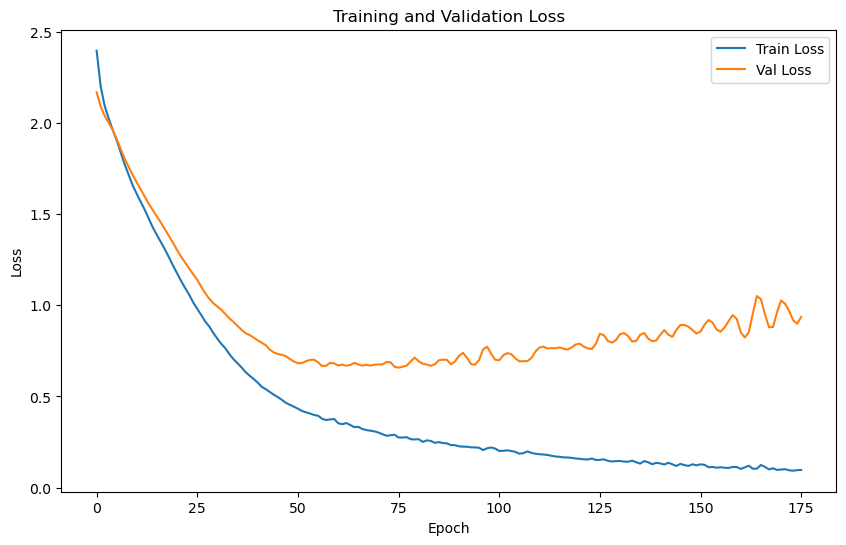

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.4400 | Test Accuracy: 65.52%


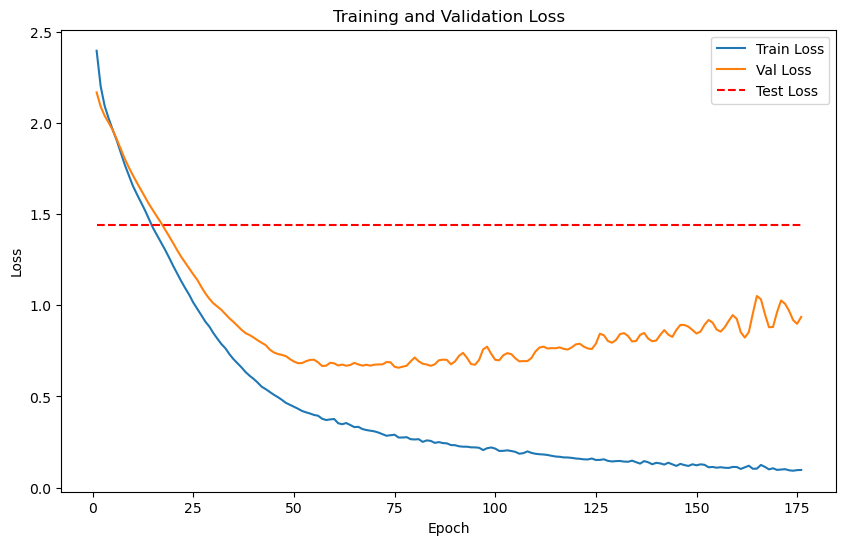

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.2200
Epoch [1/2000], Avg Train Loss: 9.2200
Epoch [1/2000], Avg Val Loss: 4.6759
Validation loss improved from inf to 4.6759. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.1422
Epoch [2/2000], Avg Train Loss: 9.1422
Epoch [2/2000], Avg Val Loss: 4.6278
Validation loss improved from 4.6759 to 4.6278. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.7613
Epoch [3/2000], Avg Train Loss: 8.7613
Epoch [3/2000], Avg Val Loss: 4.5805
Validation loss improved from 4.6278 to 4.5805. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.5192
Epoch [4/2000], Avg Train Loss: 8.5192
Epoch [4/2000], Avg Val Loss: 4.5345
Validation loss improved from 4.5805 to 4.5345. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.6272
Epoch [5/2000], Avg Train Loss: 8.6272
Epoch [5/2000], Avg Val Loss: 4.4891
Validation loss improved from 4.5345 to 4.4891. Saving mode

Epoch [10/2000], Avg Val Loss: 4.2765
Validation loss improved from 4.3171 to 4.2765. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 8.2199
Epoch [11/2000], Avg Train Loss: 8.2199
Epoch [11/2000], Avg Val Loss: 4.2369
Validation loss improved from 4.2765 to 4.2369. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.3076
Epoch [12/2000], Avg Train Loss: 8.3076
Epoch [12/2000], Avg Val Loss: 4.1984
Validation loss improved from 4.2369 to 4.1984. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 8.0952
Epoch [13/2000], Avg Train Loss: 8.0952
Epoch [13/2000], Avg Val Loss: 4.1612
Validation loss improved from 4.1984 to 4.1612. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 8.0744
Epoch [14/2000], Avg Train Loss: 8.0744
Epoch [14/2000], Avg Val Loss: 4.1249
Validation loss improved from 4.1612 to 4.1249. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Trai

Epoch [22/2000], Avg Val Loss: 3.8715
Validation loss improved from 3.9003 to 3.8715. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.6797
Epoch [23/2000], Avg Train Loss: 7.6797
Epoch [23/2000], Avg Val Loss: 3.8436
Validation loss improved from 3.8715 to 3.8436. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.2786
Epoch [24/2000], Avg Train Loss: 7.2786
Epoch [24/2000], Avg Val Loss: 3.8165
Validation loss improved from 3.8436 to 3.8165. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.2819
Epoch [25/2000], Avg Train Loss: 7.2819
Epoch [25/2000], Avg Val Loss: 3.7901
Validation loss improved from 3.8165 to 3.7901. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.2698
Epoch [26/2000], Avg Train Loss: 7.2698
Epoch [26/2000], Avg Val Loss: 3.7646
Validation loss improved from 3.7901 to 3.7646. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.7223
Epoch [33/2000], Avg Train Loss: 6.7223
Epoch [33/2000], Avg Val Loss: 3.6076
Validation loss improved from 3.6280 to 3.6076. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.6268
Epoch [34/2000], Avg Train Loss: 6.6268
Epoch [34/2000], Avg Val Loss: 3.5877
Validation loss improved from 3.6076 to 3.5877. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.7128
Epoch [35/2000], Avg Train Loss: 6.7128
Epoch [35/2000], Avg Val Loss: 3.5685
Validation loss improved from 3.5877 to 3.5685. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.5617
Epoch [36/2000], Avg Train Loss: 6.5617
Epoch [36/2000], Avg Val Loss: 3.5499
Validation loss improved from 3.5685 to 3.5499. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.5699
Epoch [37/2000], Avg Train Loss: 6.5699
Epoch [37/2000], Avg Val Loss: 3.5318
Validation loss improved from 3.5499 to 3.

    Batch [1/1], Train Loss: 6.0188
Epoch [49/2000], Avg Train Loss: 6.0188
Epoch [49/2000], Avg Val Loss: 3.3554
Validation loss improved from 3.3677 to 3.3554. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.9295
Epoch [50/2000], Avg Train Loss: 5.9295
Epoch [50/2000], Avg Val Loss: 3.3435
Validation loss improved from 3.3554 to 3.3435. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.9254
Epoch [51/2000], Avg Train Loss: 5.9254
Epoch [51/2000], Avg Val Loss: 3.3320
Validation loss improved from 3.3435 to 3.3320. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.8398
Epoch [52/2000], Avg Train Loss: 5.8398
Epoch [52/2000], Avg Val Loss: 3.3209
Validation loss improved from 3.3320 to 3.3209. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.6870
Epoch [53/2000], Avg Train Loss: 5.6870
Epoch [53/2000], Avg Val Loss: 3.3102
Validation loss improved from 3.3209 to 3.

    Batch [1/1], Train Loss: 5.3799
Epoch [59/2000], Avg Train Loss: 5.3799
Epoch [59/2000], Avg Val Loss: 3.2527
Validation loss improved from 3.2615 to 3.2527. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.6325
Epoch [60/2000], Avg Train Loss: 5.6325
Epoch [60/2000], Avg Val Loss: 3.2442
Validation loss improved from 3.2527 to 3.2442. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.4559
Epoch [61/2000], Avg Train Loss: 5.4559
Epoch [61/2000], Avg Val Loss: 3.2361
Validation loss improved from 3.2442 to 3.2361. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.6793
Epoch [62/2000], Avg Train Loss: 5.6793
Epoch [62/2000], Avg Val Loss: 3.2280
Validation loss improved from 3.2361 to 3.2280. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.3818
Epoch [63/2000], Avg Train Loss: 5.3818
Epoch [63/2000], Avg Val Loss: 3.2203
Validation loss improved from 3.2280 to 3.

Epoch [68/2000], Avg Val Loss: 3.1852
Validation loss improved from 3.1917 to 3.1852. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.3460
Epoch [69/2000], Avg Train Loss: 5.3460
Epoch [69/2000], Avg Val Loss: 3.1788
Validation loss improved from 3.1852 to 3.1788. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.3213
Epoch [70/2000], Avg Train Loss: 5.3213
Epoch [70/2000], Avg Val Loss: 3.1726
Validation loss improved from 3.1788 to 3.1726. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.2417
Epoch [71/2000], Avg Train Loss: 5.2417
Epoch [71/2000], Avg Val Loss: 3.1667
Validation loss improved from 3.1726 to 3.1667. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.2541
Epoch [72/2000], Avg Train Loss: 5.2541
Epoch [72/2000], Avg Val Loss: 3.1609
Validation loss improved from 3.1667 to 3.1609. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.0814
Epoch [78/2000], Avg Train Loss: 5.0814
Epoch [78/2000], Avg Val Loss: 3.1299
Validation loss improved from 3.1346 to 3.1299. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.0007
Epoch [79/2000], Avg Train Loss: 5.0007
Epoch [79/2000], Avg Val Loss: 3.1252
Validation loss improved from 3.1299 to 3.1252. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.9525
Epoch [80/2000], Avg Train Loss: 4.9525
Epoch [80/2000], Avg Val Loss: 3.1207
Validation loss improved from 3.1252 to 3.1207. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 4.9487
Epoch [81/2000], Avg Train Loss: 4.9487
Epoch [81/2000], Avg Val Loss: 3.1163
Validation loss improved from 3.1207 to 3.1163. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 4.9417
Epoch [82/2000], Avg Train Loss: 4.9417
Epoch [82/2000], Avg Val Loss: 3.1120
Validation loss improved from 3.1163 to 3.

    Batch [1/1], Train Loss: 4.8378
Epoch [94/2000], Avg Train Loss: 4.8378
Epoch [94/2000], Avg Val Loss: 3.0685
Validation loss improved from 3.0716 to 3.0685. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.7778
Epoch [95/2000], Avg Train Loss: 4.7778
Epoch [95/2000], Avg Val Loss: 3.0655
Validation loss improved from 3.0685 to 3.0655. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.6394
Epoch [96/2000], Avg Train Loss: 4.6394
Epoch [96/2000], Avg Val Loss: 3.0626
Validation loss improved from 3.0655 to 3.0626. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.7186
Epoch [97/2000], Avg Train Loss: 4.7186
Epoch [97/2000], Avg Val Loss: 3.0598
Validation loss improved from 3.0626 to 3.0598. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.6268
Epoch [98/2000], Avg Train Loss: 4.6268
Epoch [98/2000], Avg Val Loss: 3.0570
Validation loss improved from 3.0598 to 3.

    Batch [1/1], Train Loss: 4.5664
Epoch [105/2000], Avg Train Loss: 4.5664
Epoch [105/2000], Avg Val Loss: 3.0395
Validation loss improved from 3.0418 to 3.0395. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.5934
Epoch [106/2000], Avg Train Loss: 4.5934
Epoch [106/2000], Avg Val Loss: 3.0373
Validation loss improved from 3.0395 to 3.0373. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.6677
Epoch [107/2000], Avg Train Loss: 4.6677
Epoch [107/2000], Avg Val Loss: 3.0351
Validation loss improved from 3.0373 to 3.0351. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.5509
Epoch [108/2000], Avg Train Loss: 4.5509
Epoch [108/2000], Avg Val Loss: 3.0329
Validation loss improved from 3.0351 to 3.0329. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.5096
Epoch [109/2000], Avg Train Loss: 4.5096
Epoch [109/2000], Avg Val Loss: 3.0307
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5019
Epoch [114/2000], Avg Train Loss: 4.5019
Epoch [114/2000], Avg Val Loss: 3.0204
Validation loss improved from 3.0223 to 3.0204. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.4588
Epoch [115/2000], Avg Train Loss: 4.4588
Epoch [115/2000], Avg Val Loss: 3.0184
Validation loss improved from 3.0204 to 3.0184. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.4643
Epoch [116/2000], Avg Train Loss: 4.4643
Epoch [116/2000], Avg Val Loss: 3.0166
Validation loss improved from 3.0184 to 3.0166. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.4166
Epoch [117/2000], Avg Train Loss: 4.4166
Epoch [117/2000], Avg Val Loss: 3.0147
Validation loss improved from 3.0166 to 3.0147. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.4412
Epoch [118/2000], Avg Train Loss: 4.4412
Epoch [118/2000], Avg Val Loss: 3.0130
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2953
Epoch [125/2000], Avg Train Loss: 4.2953
Epoch [125/2000], Avg Val Loss: 3.0019
Validation loss improved from 3.0034 to 3.0019. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.3250
Epoch [126/2000], Avg Train Loss: 4.3250
Epoch [126/2000], Avg Val Loss: 3.0005
Validation loss improved from 3.0019 to 3.0005. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.2833
Epoch [127/2000], Avg Train Loss: 4.2833
Epoch [127/2000], Avg Val Loss: 2.9990
Validation loss improved from 3.0005 to 2.9990. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.3667
Epoch [128/2000], Avg Train Loss: 4.3667
Epoch [128/2000], Avg Val Loss: 2.9976
Validation loss improved from 2.9990 to 2.9976. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.3292
Epoch [129/2000], Avg Train Loss: 4.3292
Epoch [129/2000], Avg Val Loss: 2.9962
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2582
Epoch [143/2000], Avg Train Loss: 4.2582
Epoch [143/2000], Avg Val Loss: 2.9784
Validation loss improved from 2.9796 to 2.9784. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.2424
Epoch [144/2000], Avg Train Loss: 4.2424
Epoch [144/2000], Avg Val Loss: 2.9773
Validation loss improved from 2.9784 to 2.9773. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.1762
Epoch [145/2000], Avg Train Loss: 4.1762
Epoch [145/2000], Avg Val Loss: 2.9762
Validation loss improved from 2.9773 to 2.9762. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.2774
Epoch [146/2000], Avg Train Loss: 4.2774
Epoch [146/2000], Avg Val Loss: 2.9750
Validation loss improved from 2.9762 to 2.9750. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.2267
Epoch [147/2000], Avg Train Loss: 4.2267
Epoch [147/2000], Avg Val Loss: 2.9739
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2328
Epoch [156/2000], Avg Train Loss: 4.2328
Epoch [156/2000], Avg Val Loss: 2.9642
Validation loss improved from 2.9652 to 2.9642. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.1350
Epoch [157/2000], Avg Train Loss: 4.1350
Epoch [157/2000], Avg Val Loss: 2.9632
Validation loss improved from 2.9642 to 2.9632. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.2532
Epoch [158/2000], Avg Train Loss: 4.2532
Epoch [158/2000], Avg Val Loss: 2.9621
Validation loss improved from 2.9632 to 2.9621. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.1828
Epoch [159/2000], Avg Train Loss: 4.1828
Epoch [159/2000], Avg Val Loss: 2.9610
Validation loss improved from 2.9621 to 2.9610. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.1439
Epoch [160/2000], Avg Train Loss: 4.1439
Epoch [160/2000], Avg Val Loss: 2.9599
Validation loss improved fro

Epoch [174/2000], Avg Val Loss: 2.9458
Validation loss improved from 2.9468 to 2.9458. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.0846
Epoch [175/2000], Avg Train Loss: 4.0846
Epoch [175/2000], Avg Val Loss: 2.9448
Validation loss improved from 2.9458 to 2.9448. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.0772
Epoch [176/2000], Avg Train Loss: 4.0772
Epoch [176/2000], Avg Val Loss: 2.9439
Validation loss improved from 2.9448 to 2.9439. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.0370
Epoch [177/2000], Avg Train Loss: 4.0370
Epoch [177/2000], Avg Val Loss: 2.9429
Validation loss improved from 2.9439 to 2.9429. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.0433
Epoch [178/2000], Avg Train Loss: 4.0433
Epoch [178/2000], Avg Val Loss: 2.9420
Validation loss improved from 2.9429 to 2.9420. Saving model...

LOG: Epoch [179/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9898
Epoch [186/2000], Avg Train Loss: 3.9898
Epoch [186/2000], Avg Val Loss: 2.9346
Validation loss improved from 2.9355 to 2.9346. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 3.9752
Epoch [187/2000], Avg Train Loss: 3.9752
Epoch [187/2000], Avg Val Loss: 2.9337
Validation loss improved from 2.9346 to 2.9337. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 3.9946
Epoch [188/2000], Avg Train Loss: 3.9946
Epoch [188/2000], Avg Val Loss: 2.9329
Validation loss improved from 2.9337 to 2.9329. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 3.9663
Epoch [189/2000], Avg Train Loss: 3.9663
Epoch [189/2000], Avg Val Loss: 2.9320
Validation loss improved from 2.9329 to 2.9320. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 3.9554
Epoch [190/2000], Avg Train Loss: 3.9554
Epoch [190/2000], Avg Val Loss: 2.9312
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9962
Epoch [204/2000], Avg Train Loss: 3.9962
Epoch [204/2000], Avg Val Loss: 2.9186
Validation loss improved from 2.9195 to 2.9186. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 3.9825
Epoch [205/2000], Avg Train Loss: 3.9825
Epoch [205/2000], Avg Val Loss: 2.9177
Validation loss improved from 2.9186 to 2.9177. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 3.9411
Epoch [206/2000], Avg Train Loss: 3.9411
Epoch [206/2000], Avg Val Loss: 2.9168
Validation loss improved from 2.9177 to 2.9168. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 3.9371
Epoch [207/2000], Avg Train Loss: 3.9371
Epoch [207/2000], Avg Val Loss: 2.9159
Validation loss improved from 2.9168 to 2.9159. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 3.9918
Epoch [208/2000], Avg Train Loss: 3.9918
Epoch [208/2000], Avg Val Loss: 2.9150
Validation loss improved fro

Epoch [221/2000], Avg Val Loss: 2.9040
Validation loss improved from 2.9048 to 2.9040. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 3.9453
Epoch [222/2000], Avg Train Loss: 3.9453
Epoch [222/2000], Avg Val Loss: 2.9032
Validation loss improved from 2.9040 to 2.9032. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 3.8673
Epoch [223/2000], Avg Train Loss: 3.8673
Epoch [223/2000], Avg Val Loss: 2.9024
Validation loss improved from 2.9032 to 2.9024. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 3.8539
Epoch [224/2000], Avg Train Loss: 3.8539
Epoch [224/2000], Avg Val Loss: 2.9016
Validation loss improved from 2.9024 to 2.9016. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 3.8403
Epoch [225/2000], Avg Train Loss: 3.8403
Epoch [225/2000], Avg Val Loss: 2.9008
Validation loss improved from 2.9016 to 2.9008. Saving model...

LOG: Epoch [226/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8368
Epoch [233/2000], Avg Train Loss: 3.8368
Epoch [233/2000], Avg Val Loss: 2.8947
Validation loss improved from 2.8955 to 2.8947. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 3.8811
Epoch [234/2000], Avg Train Loss: 3.8811
Epoch [234/2000], Avg Val Loss: 2.8939
Validation loss improved from 2.8947 to 2.8939. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.8460
Epoch [235/2000], Avg Train Loss: 3.8460
Epoch [235/2000], Avg Val Loss: 2.8931
Validation loss improved from 2.8939 to 2.8931. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 3.8164
Epoch [236/2000], Avg Train Loss: 3.8164
Epoch [236/2000], Avg Val Loss: 2.8923
Validation loss improved from 2.8931 to 2.8923. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.7895
Epoch [237/2000], Avg Train Loss: 3.7895
Epoch [237/2000], Avg Val Loss: 2.8915
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8697
Epoch [257/2000], Avg Train Loss: 3.8697
Epoch [257/2000], Avg Val Loss: 2.8770
Validation loss improved from 2.8777 to 2.8770. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 3.8035
Epoch [258/2000], Avg Train Loss: 3.8035
Epoch [258/2000], Avg Val Loss: 2.8763
Validation loss improved from 2.8770 to 2.8763. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 3.8030
Epoch [259/2000], Avg Train Loss: 3.8030
Epoch [259/2000], Avg Val Loss: 2.8756
Validation loss improved from 2.8763 to 2.8756. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 3.7681
Epoch [260/2000], Avg Train Loss: 3.7681
Epoch [260/2000], Avg Val Loss: 2.8749
Validation loss improved from 2.8756 to 2.8749. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.8139
Epoch [261/2000], Avg Train Loss: 3.8139
Epoch [261/2000], Avg Val Loss: 2.8742
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7102
Epoch [275/2000], Avg Train Loss: 3.7102
Epoch [275/2000], Avg Val Loss: 2.8644
Validation loss improved from 2.8650 to 2.8644. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 3.7009
Epoch [276/2000], Avg Train Loss: 3.7009
Epoch [276/2000], Avg Val Loss: 2.8638
Validation loss improved from 2.8644 to 2.8638. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 3.7442
Epoch [277/2000], Avg Train Loss: 3.7442
Epoch [277/2000], Avg Val Loss: 2.8631
Validation loss improved from 2.8638 to 2.8631. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 3.7835
Epoch [278/2000], Avg Train Loss: 3.7835
Epoch [278/2000], Avg Val Loss: 2.8624
Validation loss improved from 2.8631 to 2.8624. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.7522
Epoch [279/2000], Avg Train Loss: 3.7522
Epoch [279/2000], Avg Val Loss: 2.8618
Validation loss improved fro

Epoch [284/2000], Avg Val Loss: 2.8585
Validation loss improved from 2.8592 to 2.8585. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 3.7473
Epoch [285/2000], Avg Train Loss: 3.7473
Epoch [285/2000], Avg Val Loss: 2.8578
Validation loss improved from 2.8585 to 2.8578. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 3.6962
Epoch [286/2000], Avg Train Loss: 3.6962
Epoch [286/2000], Avg Val Loss: 2.8571
Validation loss improved from 2.8578 to 2.8571. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 3.7013
Epoch [287/2000], Avg Train Loss: 3.7013
Epoch [287/2000], Avg Val Loss: 2.8563
Validation loss improved from 2.8571 to 2.8563. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 3.6677
Epoch [288/2000], Avg Train Loss: 3.6677
Epoch [288/2000], Avg Val Loss: 2.8556
Validation loss improved from 2.8563 to 2.8556. Saving model...

LOG: Epoch [289/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7664
Epoch [299/2000], Avg Train Loss: 3.7664
Epoch [299/2000], Avg Val Loss: 2.8477
Validation loss improved from 2.8485 to 2.8477. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.7456
Epoch [300/2000], Avg Train Loss: 3.7456
Epoch [300/2000], Avg Val Loss: 2.8470
Validation loss improved from 2.8477 to 2.8470. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.7063
Epoch [301/2000], Avg Train Loss: 3.7063
Epoch [301/2000], Avg Val Loss: 2.8463
Validation loss improved from 2.8470 to 2.8463. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.7008
Epoch [302/2000], Avg Train Loss: 3.7008
Epoch [302/2000], Avg Val Loss: 2.8456
Validation loss improved from 2.8463 to 2.8456. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.7328
Epoch [303/2000], Avg Train Loss: 3.7328
Epoch [303/2000], Avg Val Loss: 2.8449
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7125
Epoch [321/2000], Avg Train Loss: 3.7125
Epoch [321/2000], Avg Val Loss: 2.8329
Validation loss improved from 2.8335 to 2.8329. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 3.7287
Epoch [322/2000], Avg Train Loss: 3.7287
Epoch [322/2000], Avg Val Loss: 2.8323
Validation loss improved from 2.8329 to 2.8323. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 3.7611
Epoch [323/2000], Avg Train Loss: 3.7611
Epoch [323/2000], Avg Val Loss: 2.8317
Validation loss improved from 2.8323 to 2.8317. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 3.6261
Epoch [324/2000], Avg Train Loss: 3.6261
Epoch [324/2000], Avg Val Loss: 2.8311
Validation loss improved from 2.8317 to 2.8311. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 3.6450
Epoch [325/2000], Avg Train Loss: 3.6450
Epoch [325/2000], Avg Val Loss: 2.8306
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6006
Epoch [328/2000], Avg Train Loss: 3.6006
Epoch [328/2000], Avg Val Loss: 2.8289
Validation loss improved from 2.8295 to 2.8289. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.6472
Epoch [329/2000], Avg Train Loss: 3.6472
Epoch [329/2000], Avg Val Loss: 2.8283
Validation loss improved from 2.8289 to 2.8283. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.5883
Epoch [330/2000], Avg Train Loss: 3.5883
Epoch [330/2000], Avg Val Loss: 2.8277
Validation loss improved from 2.8283 to 2.8277. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 3.6119
Epoch [331/2000], Avg Train Loss: 3.6119
Epoch [331/2000], Avg Val Loss: 2.8271
Validation loss improved from 2.8277 to 2.8271. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 3.6220
Epoch [332/2000], Avg Train Loss: 3.6220
Epoch [332/2000], Avg Val Loss: 2.8265
Validation loss improved fro

Epoch [347/2000], Avg Val Loss: 2.8177
Validation loss improved from 2.8183 to 2.8177. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.5520
Epoch [348/2000], Avg Train Loss: 3.5520
Epoch [348/2000], Avg Val Loss: 2.8170
Validation loss improved from 2.8177 to 2.8170. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.5550
Epoch [349/2000], Avg Train Loss: 3.5550
Epoch [349/2000], Avg Val Loss: 2.8164
Validation loss improved from 2.8170 to 2.8164. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.5285
Epoch [350/2000], Avg Train Loss: 3.5285
Epoch [350/2000], Avg Val Loss: 2.8157
Validation loss improved from 2.8164 to 2.8157. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 3.6912
Epoch [351/2000], Avg Train Loss: 3.6912
Epoch [351/2000], Avg Val Loss: 2.8151
Validation loss improved from 2.8157 to 2.8151. Saving model...

LOG: Epoch [352/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5956
Epoch [371/2000], Avg Train Loss: 3.5956
Epoch [371/2000], Avg Val Loss: 2.8044
Validation loss improved from 2.8050 to 2.8044. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.5475
Epoch [372/2000], Avg Train Loss: 3.5475
Epoch [372/2000], Avg Val Loss: 2.8039
Validation loss improved from 2.8044 to 2.8039. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.5432
Epoch [373/2000], Avg Train Loss: 3.5432
Epoch [373/2000], Avg Val Loss: 2.8034
Validation loss improved from 2.8039 to 2.8034. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 3.5827
Epoch [374/2000], Avg Train Loss: 3.5827
Epoch [374/2000], Avg Val Loss: 2.8028
Validation loss improved from 2.8034 to 2.8028. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 3.5659
Epoch [375/2000], Avg Train Loss: 3.5659
Epoch [375/2000], Avg Val Loss: 2.8023
Validation loss improved fro

Epoch [389/2000], Avg Val Loss: 2.7944
Validation loss improved from 2.7950 to 2.7944. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 3.5156
Epoch [390/2000], Avg Train Loss: 3.5156
Epoch [390/2000], Avg Val Loss: 2.7938
Validation loss improved from 2.7944 to 2.7938. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 3.5779
Epoch [391/2000], Avg Train Loss: 3.5779
Epoch [391/2000], Avg Val Loss: 2.7933
Validation loss improved from 2.7938 to 2.7933. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.5437
Epoch [392/2000], Avg Train Loss: 3.5437
Epoch [392/2000], Avg Val Loss: 2.7927
Validation loss improved from 2.7933 to 2.7927. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.5337
Epoch [393/2000], Avg Train Loss: 3.5337
Epoch [393/2000], Avg Val Loss: 2.7921
Validation loss improved from 2.7927 to 2.7921. Saving model...

LOG: Epoch [394/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5490
Epoch [413/2000], Avg Train Loss: 3.5490
Epoch [413/2000], Avg Val Loss: 2.7826
Validation loss improved from 2.7831 to 2.7826. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 3.5717
Epoch [414/2000], Avg Train Loss: 3.5717
Epoch [414/2000], Avg Val Loss: 2.7821
Validation loss improved from 2.7826 to 2.7821. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 3.5462
Epoch [415/2000], Avg Train Loss: 3.5462
Epoch [415/2000], Avg Val Loss: 2.7816
Validation loss improved from 2.7821 to 2.7816. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 3.4766
Epoch [416/2000], Avg Train Loss: 3.4766
Epoch [416/2000], Avg Val Loss: 2.7812
Validation loss improved from 2.7816 to 2.7812. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.4832
Epoch [417/2000], Avg Train Loss: 3.4832
Epoch [417/2000], Avg Val Loss: 2.7807
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4711
Epoch [432/2000], Avg Train Loss: 3.4711
Epoch [432/2000], Avg Val Loss: 2.7739
Validation loss improved from 2.7743 to 2.7739. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 3.4768
Epoch [433/2000], Avg Train Loss: 3.4768
Epoch [433/2000], Avg Val Loss: 2.7734
Validation loss improved from 2.7739 to 2.7734. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 3.5059
Epoch [434/2000], Avg Train Loss: 3.5059
Epoch [434/2000], Avg Val Loss: 2.7730
Validation loss improved from 2.7734 to 2.7730. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 3.4891
Epoch [435/2000], Avg Train Loss: 3.4891
Epoch [435/2000], Avg Val Loss: 2.7725
Validation loss improved from 2.7730 to 2.7725. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.4816
Epoch [436/2000], Avg Train Loss: 3.4816
Epoch [436/2000], Avg Val Loss: 2.7721
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4410
Epoch [455/2000], Avg Train Loss: 3.4410
Epoch [455/2000], Avg Val Loss: 2.7634
Validation loss improved from 2.7639 to 2.7634. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 3.4452
Epoch [456/2000], Avg Train Loss: 3.4452
Epoch [456/2000], Avg Val Loss: 2.7629
Validation loss improved from 2.7634 to 2.7629. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 3.5173
Epoch [457/2000], Avg Train Loss: 3.5173
Epoch [457/2000], Avg Val Loss: 2.7625
Validation loss improved from 2.7629 to 2.7625. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 3.4665
Epoch [458/2000], Avg Train Loss: 3.4665
Epoch [458/2000], Avg Val Loss: 2.7621
Validation loss improved from 2.7625 to 2.7621. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.4089
Epoch [459/2000], Avg Train Loss: 3.4089
Epoch [459/2000], Avg Val Loss: 2.7617
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4335
Epoch [474/2000], Avg Train Loss: 3.4335
Epoch [474/2000], Avg Val Loss: 2.7554
Validation loss improved from 2.7559 to 2.7554. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 3.4970
Epoch [475/2000], Avg Train Loss: 3.4970
Epoch [475/2000], Avg Val Loss: 2.7550
Validation loss improved from 2.7554 to 2.7550. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 3.4215
Epoch [476/2000], Avg Train Loss: 3.4215
Epoch [476/2000], Avg Val Loss: 2.7545
Validation loss improved from 2.7550 to 2.7545. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 3.4267
Epoch [477/2000], Avg Train Loss: 3.4267
Epoch [477/2000], Avg Val Loss: 2.7541
Validation loss improved from 2.7545 to 2.7541. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 3.3997
Epoch [478/2000], Avg Train Loss: 3.3997
Epoch [478/2000], Avg Val Loss: 2.7537
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3864
Epoch [501/2000], Avg Train Loss: 3.3864
Epoch [501/2000], Avg Val Loss: 2.7460
Validation loss improved from 2.7463 to 2.7460. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 3.4012
Epoch [502/2000], Avg Train Loss: 3.4012
Epoch [502/2000], Avg Val Loss: 2.7456
Validation loss improved from 2.7460 to 2.7456. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 3.3603
Epoch [503/2000], Avg Train Loss: 3.3603
Epoch [503/2000], Avg Val Loss: 2.7452
Validation loss improved from 2.7456 to 2.7452. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 3.3915
Epoch [504/2000], Avg Train Loss: 3.3915
Epoch [504/2000], Avg Val Loss: 2.7447
Validation loss improved from 2.7452 to 2.7447. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.3845
Epoch [505/2000], Avg Train Loss: 3.3845
Epoch [505/2000], Avg Val Loss: 2.7443
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4466
Epoch [521/2000], Avg Train Loss: 3.4466
Epoch [521/2000], Avg Val Loss: 2.7384
Validation loss improved from 2.7387 to 2.7384. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 3.3517
Epoch [522/2000], Avg Train Loss: 3.3517
Epoch [522/2000], Avg Val Loss: 2.7380
Validation loss improved from 2.7384 to 2.7380. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 3.3508
Epoch [523/2000], Avg Train Loss: 3.3508
Epoch [523/2000], Avg Val Loss: 2.7378
Validation loss improved from 2.7380 to 2.7378. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 3.3894
Epoch [524/2000], Avg Train Loss: 3.3894
Epoch [524/2000], Avg Val Loss: 2.7374
Validation loss improved from 2.7378 to 2.7374. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.4068
Epoch [525/2000], Avg Train Loss: 3.4068
Epoch [525/2000], Avg Val Loss: 2.7371
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3443
Epoch [548/2000], Avg Train Loss: 3.3443
Epoch [548/2000], Avg Val Loss: 2.7293
Validation loss improved from 2.7296 to 2.7293. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 3.3431
Epoch [549/2000], Avg Train Loss: 3.3431
Epoch [549/2000], Avg Val Loss: 2.7290
Validation loss improved from 2.7293 to 2.7290. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 3.3260
Epoch [550/2000], Avg Train Loss: 3.3260
Epoch [550/2000], Avg Val Loss: 2.7287
Validation loss improved from 2.7290 to 2.7287. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.2919
Epoch [551/2000], Avg Train Loss: 3.2919
Epoch [551/2000], Avg Val Loss: 2.7283
Validation loss improved from 2.7287 to 2.7283. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.3599
Epoch [552/2000], Avg Train Loss: 3.3599
Epoch [552/2000], Avg Val Loss: 2.7280
Validation loss improved fro

Epoch [569/2000], Avg Val Loss: 2.7224
Validation loss improved from 2.7226 to 2.7224. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 3.3240
Epoch [570/2000], Avg Train Loss: 3.3240
Epoch [570/2000], Avg Val Loss: 2.7221
Validation loss improved from 2.7224 to 2.7221. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 3.3277
Epoch [571/2000], Avg Train Loss: 3.3277
Epoch [571/2000], Avg Val Loss: 2.7219
Validation loss improved from 2.7221 to 2.7219. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.3070
Epoch [572/2000], Avg Train Loss: 3.3070
Epoch [572/2000], Avg Val Loss: 2.7217
Validation loss improved from 2.7219 to 2.7217. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.3257
Epoch [573/2000], Avg Train Loss: 3.3257
Epoch [573/2000], Avg Val Loss: 2.7215
Validation loss improved from 2.7217 to 2.7215. Saving model...

LOG: Epoch [574/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2772
Epoch [595/2000], Avg Train Loss: 3.2772
Epoch [595/2000], Avg Val Loss: 2.7179
Validation loss improved from 2.7181 to 2.7179. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 3.3431
Epoch [596/2000], Avg Train Loss: 3.3431
Epoch [596/2000], Avg Val Loss: 2.7178
Validation loss improved from 2.7179 to 2.7178. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 3.3288
Epoch [597/2000], Avg Train Loss: 3.3288
Epoch [597/2000], Avg Val Loss: 2.7177
Validation loss improved from 2.7178 to 2.7177. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.3120
Epoch [598/2000], Avg Train Loss: 3.3120
Epoch [598/2000], Avg Val Loss: 2.7175
Validation loss improved from 2.7177 to 2.7175. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 3.3013
Epoch [599/2000], Avg Train Loss: 3.3013
Epoch [599/2000], Avg Val Loss: 2.7174
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2877
Epoch [615/2000], Avg Train Loss: 3.2877
Epoch [615/2000], Avg Val Loss: 2.7144
Validation loss improved from 2.7147 to 2.7144. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.3307
Epoch [616/2000], Avg Train Loss: 3.3307
Epoch [616/2000], Avg Val Loss: 2.7140
Validation loss improved from 2.7144 to 2.7140. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.3189
Epoch [617/2000], Avg Train Loss: 3.3189
Epoch [617/2000], Avg Val Loss: 2.7137
Validation loss improved from 2.7140 to 2.7137. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 3.2628
Epoch [618/2000], Avg Train Loss: 3.2628
Epoch [618/2000], Avg Val Loss: 2.7133
Validation loss improved from 2.7137 to 2.7133. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 3.3039
Epoch [619/2000], Avg Train Loss: 3.3039
Epoch [619/2000], Avg Val Loss: 2.7130
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3067
Epoch [638/2000], Avg Train Loss: 3.3067
Epoch [638/2000], Avg Val Loss: 2.7081
Validation loss improved from 2.7083 to 2.7081. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.3236
Epoch [639/2000], Avg Train Loss: 3.3236
Epoch [639/2000], Avg Val Loss: 2.7079
Validation loss improved from 2.7081 to 2.7079. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 3.2929
Epoch [640/2000], Avg Train Loss: 3.2929
Epoch [640/2000], Avg Val Loss: 2.7077
Validation loss improved from 2.7079 to 2.7077. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 3.2939
Epoch [641/2000], Avg Train Loss: 3.2939
Epoch [641/2000], Avg Val Loss: 2.7075
Validation loss improved from 2.7077 to 2.7075. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 3.2443
Epoch [642/2000], Avg Train Loss: 3.2443
Epoch [642/2000], Avg Val Loss: 2.7073
Validation loss improved fro

Epoch [661/2000], Avg Val Loss: 2.7053
Validation loss improved from 2.7053 to 2.7053. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.2663
Epoch [662/2000], Avg Train Loss: 3.2663
Epoch [662/2000], Avg Val Loss: 2.7052
Validation loss improved from 2.7053 to 2.7052. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 3.2953
Epoch [663/2000], Avg Train Loss: 3.2953
Epoch [663/2000], Avg Val Loss: 2.7051
Validation loss improved from 2.7052 to 2.7051. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.2779
Epoch [664/2000], Avg Train Loss: 3.2779
Epoch [664/2000], Avg Val Loss: 2.7050
Validation loss improved from 2.7051 to 2.7050. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.2418
Epoch [665/2000], Avg Train Loss: 3.2418
Epoch [665/2000], Avg Val Loss: 2.7050
Validation loss improved from 2.7050 to 2.7050. Saving model...

LOG: Epoch [666/2000] - Training
    Bat

Epoch [683/2000], Avg Val Loss: 2.7035
Validation loss improved from 2.7036 to 2.7035. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.2418
Epoch [684/2000], Avg Train Loss: 3.2418
Epoch [684/2000], Avg Val Loss: 2.7035
Validation loss improved from 2.7035 to 2.7035. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 3.2330
Epoch [685/2000], Avg Train Loss: 3.2330
Epoch [685/2000], Avg Val Loss: 2.7035
Validation loss improved from 2.7035 to 2.7035. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 3.2554
Epoch [686/2000], Avg Train Loss: 3.2554
Epoch [686/2000], Avg Val Loss: 2.7035
Validation loss did not improve. Patience: 1/100

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 3.3001
Epoch [687/2000], Avg Train Loss: 3.3001
Epoch [687/2000], Avg Val Loss: 2.7036
Validation loss did not improve. Patience: 2/100

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 3.2372
E

    Batch [1/1], Train Loss: 3.2426
Epoch [708/2000], Avg Train Loss: 3.2426
Epoch [708/2000], Avg Val Loss: 2.7035
Validation loss did not improve. Patience: 23/100

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 3.2512
Epoch [709/2000], Avg Train Loss: 3.2512
Epoch [709/2000], Avg Val Loss: 2.7034
Validation loss improved from 2.7035 to 2.7034. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 3.2098
Epoch [710/2000], Avg Train Loss: 3.2098
Epoch [710/2000], Avg Val Loss: 2.7033
Validation loss improved from 2.7034 to 2.7033. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 3.2652
Epoch [711/2000], Avg Train Loss: 3.2652
Epoch [711/2000], Avg Val Loss: 2.7032
Validation loss improved from 2.7033 to 2.7032. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 3.2325
Epoch [712/2000], Avg Train Loss: 3.2325
Epoch [712/2000], Avg Val Loss: 2.7031
Validation loss improved from 2.7032 to 2.

Epoch [730/2000], Avg Val Loss: 2.7020
Validation loss improved from 2.7020 to 2.7020. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 3.2341
Epoch [731/2000], Avg Train Loss: 3.2341
Epoch [731/2000], Avg Val Loss: 2.7019
Validation loss improved from 2.7020 to 2.7019. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 3.2818
Epoch [732/2000], Avg Train Loss: 3.2818
Epoch [732/2000], Avg Val Loss: 2.7019
Validation loss improved from 2.7019 to 2.7019. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 3.2162
Epoch [733/2000], Avg Train Loss: 3.2162
Epoch [733/2000], Avg Val Loss: 2.7019
Validation loss improved from 2.7019 to 2.7019. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 3.2219
Epoch [734/2000], Avg Train Loss: 3.2219
Epoch [734/2000], Avg Val Loss: 2.7019
Validation loss did not improve. Patience: 1/100

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train

    Batch [1/1], Train Loss: 3.2262
Epoch [754/2000], Avg Train Loss: 3.2262
Epoch [754/2000], Avg Val Loss: 2.7018
Validation loss improved from 2.7019 to 2.7018. Saving model...

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 3.2186
Epoch [755/2000], Avg Train Loss: 3.2186
Epoch [755/2000], Avg Val Loss: 2.7017
Validation loss improved from 2.7018 to 2.7017. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 3.2397
Epoch [756/2000], Avg Train Loss: 3.2397
Epoch [756/2000], Avg Val Loss: 2.7015
Validation loss improved from 2.7017 to 2.7015. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 3.2230
Epoch [757/2000], Avg Train Loss: 3.2230
Epoch [757/2000], Avg Val Loss: 2.7013
Validation loss improved from 2.7015 to 2.7013. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 3.2189
Epoch [758/2000], Avg Train Loss: 3.2189
Epoch [758/2000], Avg Val Loss: 2.7011
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2023
Epoch [779/2000], Avg Train Loss: 3.2023
Epoch [779/2000], Avg Val Loss: 2.6986
Validation loss improved from 2.6987 to 2.6986. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 3.1821
Epoch [780/2000], Avg Train Loss: 3.1821
Epoch [780/2000], Avg Val Loss: 2.6986
Validation loss improved from 2.6986 to 2.6986. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 3.1736
Epoch [781/2000], Avg Train Loss: 3.1736
Epoch [781/2000], Avg Val Loss: 2.6986
Validation loss did not improve. Patience: 1/100

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 3.1886
Epoch [782/2000], Avg Train Loss: 3.1886
Epoch [782/2000], Avg Val Loss: 2.6987
Validation loss did not improve. Patience: 2/100

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 3.1875
Epoch [783/2000], Avg Train Loss: 3.1875
Epoch [783/2000], Avg Val Loss: 2.6986
Validation loss did not improve. Patience: 3/100

LOG: Epo

Epoch [801/2000], Avg Val Loss: 2.6977
Validation loss improved from 2.6978 to 2.6977. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 3.2048
Epoch [802/2000], Avg Train Loss: 3.2048
Epoch [802/2000], Avg Val Loss: 2.6976
Validation loss improved from 2.6977 to 2.6976. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 3.2147
Epoch [803/2000], Avg Train Loss: 3.2147
Epoch [803/2000], Avg Val Loss: 2.6976
Validation loss improved from 2.6976 to 2.6976. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 3.1916
Epoch [804/2000], Avg Train Loss: 3.1916
Epoch [804/2000], Avg Val Loss: 2.6975
Validation loss improved from 2.6976 to 2.6975. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.1577
Epoch [805/2000], Avg Train Loss: 3.1577
Epoch [805/2000], Avg Val Loss: 2.6976
Validation loss did not improve. Patience: 1/100

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train

    Batch [1/1], Train Loss: 3.1863
Epoch [824/2000], Avg Train Loss: 3.1863
Epoch [824/2000], Avg Val Loss: 2.7003
Validation loss did not improve. Patience: 20/100

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 3.2112
Epoch [825/2000], Avg Train Loss: 3.2112
Epoch [825/2000], Avg Val Loss: 2.7005
Validation loss did not improve. Patience: 21/100

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 3.1630
Epoch [826/2000], Avg Train Loss: 3.1630
Epoch [826/2000], Avg Val Loss: 2.7006
Validation loss did not improve. Patience: 22/100

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 3.1976
Epoch [827/2000], Avg Train Loss: 3.1976
Epoch [827/2000], Avg Val Loss: 2.7007
Validation loss did not improve. Patience: 23/100

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 3.1061
Epoch [828/2000], Avg Train Loss: 3.1061
Epoch [828/2000], Avg Val Loss: 2.7006
Validation loss did not improve. Patience: 24/100

LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 3.1464
Epoch [845/2000], Avg Train Loss: 3.1464
Epoch [845/2000], Avg Val Loss: 2.7007
Validation loss did not improve. Patience: 41/100

LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 3.1981
Epoch [846/2000], Avg Train Loss: 3.1981
Epoch [846/2000], Avg Val Loss: 2.7008
Validation loss did not improve. Patience: 42/100

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 3.1531
Epoch [847/2000], Avg Train Loss: 3.1531
Epoch [847/2000], Avg Val Loss: 2.7008
Validation loss did not improve. Patience: 43/100

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 3.1740
Epoch [848/2000], Avg Train Loss: 3.1740
Epoch [848/2000], Avg Val Loss: 2.7009
Validation loss did not improve. Patience: 44/100

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.0962
Epoch [849/2000], Avg Train Loss: 3.0962
Epoch [849/2000], Avg Val Loss: 2.7009
Validation loss did not improve. Patience: 45/100

LOG: Epoch [850/2000] - Training


Epoch [864/2000], Avg Val Loss: 2.7036
Validation loss did not improve. Patience: 60/100

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 3.1998
Epoch [865/2000], Avg Train Loss: 3.1998
Epoch [865/2000], Avg Val Loss: 2.7038
Validation loss did not improve. Patience: 61/100

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 3.1785
Epoch [866/2000], Avg Train Loss: 3.1785
Epoch [866/2000], Avg Val Loss: 2.7041
Validation loss did not improve. Patience: 62/100

LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 3.1257
Epoch [867/2000], Avg Train Loss: 3.1257
Epoch [867/2000], Avg Val Loss: 2.7044
Validation loss did not improve. Patience: 63/100

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 3.2103
Epoch [868/2000], Avg Train Loss: 3.2103
Epoch [868/2000], Avg Val Loss: 2.7047
Validation loss did not improve. Patience: 64/100

LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 3.1403
Epoch [869/2000], Avg Train Loss: 3.1403


    Batch [1/1], Train Loss: 3.1199
Epoch [887/2000], Avg Train Loss: 3.1199
Epoch [887/2000], Avg Val Loss: 2.7084
Validation loss did not improve. Patience: 83/100

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 3.1451
Epoch [888/2000], Avg Train Loss: 3.1451
Epoch [888/2000], Avg Val Loss: 2.7083
Validation loss did not improve. Patience: 84/100

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 3.1866
Epoch [889/2000], Avg Train Loss: 3.1866
Epoch [889/2000], Avg Val Loss: 2.7083
Validation loss did not improve. Patience: 85/100

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 3.1909
Epoch [890/2000], Avg Train Loss: 3.1909
Epoch [890/2000], Avg Val Loss: 2.7083
Validation loss did not improve. Patience: 86/100

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 3.1367
Epoch [891/2000], Avg Train Loss: 3.1367
Epoch [891/2000], Avg Val Loss: 2.7084
Validation loss did not improve. Patience: 87/100

LOG: Epoch [892/2000] - Training


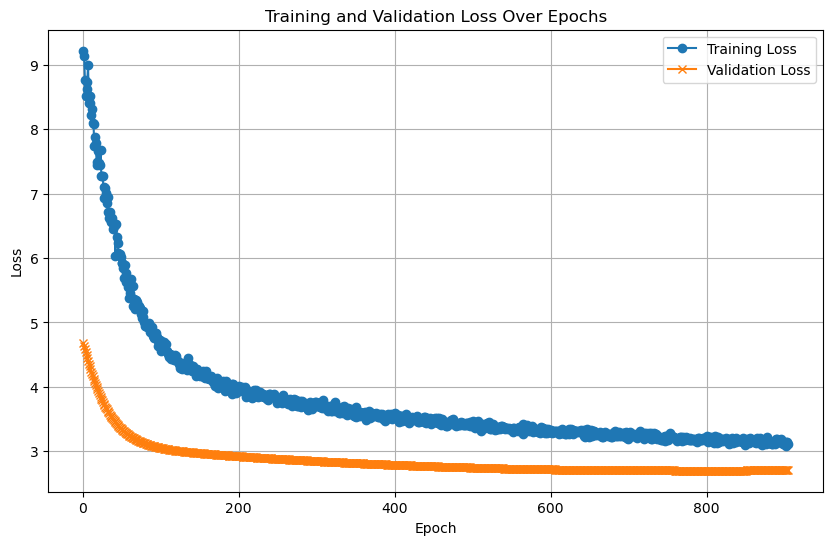

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 5.8823


Test Batch [20/167], Loss: 5.4492
Test Batch [30/167], Loss: 5.3712
Test Batch [40/167], Loss: 5.2215
Test Batch [50/167], Loss: 5.3826
Test Batch [60/167], Loss: 5.8005
Test Batch [70/167], Loss: 5.7572
Test Batch [80/167], Loss: 4.6275
Test Batch [90/167], Loss: 4.6311
Test Batch [100/167], Loss: 4.8759
Test Batch [110/167], Loss: 5.0189
Test Batch [120/167], Loss: 5.0379
Test Batch [130/167], Loss: 5.0326
Test Batch [140/167], Loss: 5.1888
Test Batch [150/167], Loss: 4.7477


Test Batch [160/167], Loss: 5.2052

Test Loss: 5.2151


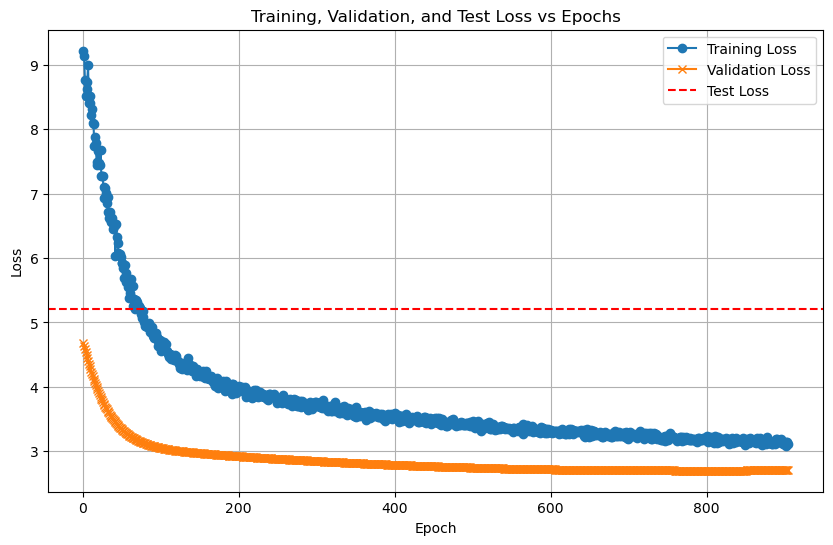

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.


  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.


  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.60      0.60      0.60         5
           2       0.40      0.40      0.40         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.60      0.60      0.60         5
           6       0.56      1.00      0.71         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5

    accuracy                           0.73        45
   macro avg       0.77      0.73      0.72        45
weighted avg       0.77      0.73      0.72        45


LOG: Evaluating on the test set...
Test Accuracy: 63.58%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4356  |  Val Loss: 2.4445
Validation loss improved from inf to 2.4445.


[Epoch 2/1000] Train Loss: 2.4024  |  Val Loss: 2.4126
Validation loss improved from 2.4445 to 2.4126.
[Epoch 3/1000] Train Loss: 2.3666  |  Val Loss: 2.3812
Validation loss improved from 2.4126 to 2.3812.
[Epoch 4/1000] Train Loss: 2.3325  |  Val Loss: 2.3492
Validation loss improved from 2.3812 to 2.3492.
[Epoch 5/1000] Train Loss: 2.2976  |  Val Loss: 2.3167
Validation loss improved from 2.3492 to 2.3167.
[Epoch 6/1000] Train Loss: 2.2626  |  Val Loss: 2.2851
Validation loss improved from 2.3167 to 2.2851.
[Epoch 7/1000] Train Loss: 2.2290  |  Val Loss: 2.2531
Validation loss improved from 2.2851 to 2.2531.
[Epoch 8/1000] Train Loss: 2.1984  |  Val Loss: 2.2225
Validation loss improved from 2.2531 to 2.2225.
[Epoch 9/1000] Train Loss: 2.1654  |  Val Loss: 2.1933
Validation loss improved from 2.2225 to 2.1933.
[Epoch 10/1000] Train Loss: 2.1344  |  Val Loss: 2.1654
Validation loss improved from 2.1933 to 2.1654.
[Epoch 11/1000] Train Loss: 2.1077  |  Val Loss: 2.1386
Validation loss 

[Epoch 42/1000] Train Loss: 1.6725  |  Val Loss: 1.7807
Validation loss improved from 1.7872 to 1.7807.


[Epoch 43/1000] Train Loss: 1.6644  |  Val Loss: 1.7742
Validation loss improved from 1.7807 to 1.7742.
[Epoch 44/1000] Train Loss: 1.6567  |  Val Loss: 1.7676
Validation loss improved from 1.7742 to 1.7676.
[Epoch 45/1000] Train Loss: 1.6489  |  Val Loss: 1.7611
Validation loss improved from 1.7676 to 1.7611.
[Epoch 46/1000] Train Loss: 1.6411  |  Val Loss: 1.7545
Validation loss improved from 1.7611 to 1.7545.
[Epoch 47/1000] Train Loss: 1.6337  |  Val Loss: 1.7480
Validation loss improved from 1.7545 to 1.7480.
[Epoch 48/1000] Train Loss: 1.6270  |  Val Loss: 1.7414
Validation loss improved from 1.7480 to 1.7414.
[Epoch 49/1000] Train Loss: 1.6196  |  Val Loss: 1.7352
Validation loss improved from 1.7414 to 1.7352.
[Epoch 50/1000] Train Loss: 1.6125  |  Val Loss: 1.7290
Validation loss improved from 1.7352 to 1.7290.
[Epoch 51/1000] Train Loss: 1.6053  |  Val Loss: 1.7226
Validation loss improved from 1.7290 to 1.7226.
[Epoch 52/1000] Train Loss: 1.5986  |  Val Loss: 1.7162
Validati

[Epoch 88/1000] Train Loss: 1.3448  |  Val Loss: 1.4925
Validation loss improved from 1.4991 to 1.4925.
[Epoch 89/1000] Train Loss: 1.3374  |  Val Loss: 1.4858
Validation loss improved from 1.4925 to 1.4858.
[Epoch 90/1000] Train Loss: 1.3298  |  Val Loss: 1.4791
Validation loss improved from 1.4858 to 1.4791.
[Epoch 91/1000] Train Loss: 1.3223  |  Val Loss: 1.4726
Validation loss improved from 1.4791 to 1.4726.
[Epoch 92/1000] Train Loss: 1.3147  |  Val Loss: 1.4660
Validation loss improved from 1.4726 to 1.4660.
[Epoch 93/1000] Train Loss: 1.3068  |  Val Loss: 1.4591
Validation loss improved from 1.4660 to 1.4591.
[Epoch 94/1000] Train Loss: 1.2991  |  Val Loss: 1.4521
Validation loss improved from 1.4591 to 1.4521.
[Epoch 95/1000] Train Loss: 1.2914  |  Val Loss: 1.4451
Validation loss improved from 1.4521 to 1.4451.
[Epoch 96/1000] Train Loss: 1.2837  |  Val Loss: 1.4382
Validation loss improved from 1.4451 to 1.4382.
[Epoch 97/1000] Train Loss: 1.2760  |  Val Loss: 1.4313
Validati

[Epoch 133/1000] Train Loss: 0.9990  |  Val Loss: 1.1861
Validation loss improved from 1.1920 to 1.1861.
[Epoch 134/1000] Train Loss: 0.9920  |  Val Loss: 1.1802
Validation loss improved from 1.1861 to 1.1802.
[Epoch 135/1000] Train Loss: 0.9853  |  Val Loss: 1.1742
Validation loss improved from 1.1802 to 1.1742.
[Epoch 136/1000] Train Loss: 0.9784  |  Val Loss: 1.1685
Validation loss improved from 1.1742 to 1.1685.
[Epoch 137/1000] Train Loss: 0.9719  |  Val Loss: 1.1626
Validation loss improved from 1.1685 to 1.1626.
[Epoch 138/1000] Train Loss: 0.9653  |  Val Loss: 1.1566
Validation loss improved from 1.1626 to 1.1566.
[Epoch 139/1000] Train Loss: 0.9583  |  Val Loss: 1.1509
Validation loss improved from 1.1566 to 1.1509.
[Epoch 140/1000] Train Loss: 0.9517  |  Val Loss: 1.1455
Validation loss improved from 1.1509 to 1.1455.
[Epoch 141/1000] Train Loss: 0.9453  |  Val Loss: 1.1402
Validation loss improved from 1.1455 to 1.1402.
[Epoch 142/1000] Train Loss: 0.9389  |  Val Loss: 1.134

[Epoch 175/1000] Train Loss: 0.7633  |  Val Loss: 0.9794
Validation loss improved from 0.9836 to 0.9794.
[Epoch 176/1000] Train Loss: 0.7588  |  Val Loss: 0.9748
Validation loss improved from 0.9794 to 0.9748.
[Epoch 177/1000] Train Loss: 0.7541  |  Val Loss: 0.9702
Validation loss improved from 0.9748 to 0.9702.
[Epoch 178/1000] Train Loss: 0.7497  |  Val Loss: 0.9659
Validation loss improved from 0.9702 to 0.9659.
[Epoch 179/1000] Train Loss: 0.7453  |  Val Loss: 0.9615
Validation loss improved from 0.9659 to 0.9615.
[Epoch 180/1000] Train Loss: 0.7410  |  Val Loss: 0.9575
Validation loss improved from 0.9615 to 0.9575.
[Epoch 181/1000] Train Loss: 0.7367  |  Val Loss: 0.9539
Validation loss improved from 0.9575 to 0.9539.
[Epoch 182/1000] Train Loss: 0.7325  |  Val Loss: 0.9505
Validation loss improved from 0.9539 to 0.9505.
[Epoch 183/1000] Train Loss: 0.7281  |  Val Loss: 0.9473
Validation loss improved from 0.9505 to 0.9473.
[Epoch 184/1000] Train Loss: 0.7238  |  Val Loss: 0.944

[Epoch 217/1000] Train Loss: 0.6065  |  Val Loss: 0.8575
Validation loss improved from 0.8597 to 0.8575.
[Epoch 218/1000] Train Loss: 0.6034  |  Val Loss: 0.8551
Validation loss improved from 0.8575 to 0.8551.
[Epoch 219/1000] Train Loss: 0.6005  |  Val Loss: 0.8529
Validation loss improved from 0.8551 to 0.8529.
[Epoch 220/1000] Train Loss: 0.5975  |  Val Loss: 0.8505
Validation loss improved from 0.8529 to 0.8505.
[Epoch 221/1000] Train Loss: 0.5947  |  Val Loss: 0.8478
Validation loss improved from 0.8505 to 0.8478.
[Epoch 222/1000] Train Loss: 0.5919  |  Val Loss: 0.8448
Validation loss improved from 0.8478 to 0.8448.
[Epoch 223/1000] Train Loss: 0.5895  |  Val Loss: 0.8421
Validation loss improved from 0.8448 to 0.8421.
[Epoch 224/1000] Train Loss: 0.5865  |  Val Loss: 0.8405
Validation loss improved from 0.8421 to 0.8405.
[Epoch 225/1000] Train Loss: 0.5837  |  Val Loss: 0.8389
Validation loss improved from 0.8405 to 0.8389.
[Epoch 226/1000] Train Loss: 0.5810  |  Val Loss: 0.837

[Epoch 267/1000] Train Loss: 0.4880  |  Val Loss: 0.7751
Validation loss improved from 0.7756 to 0.7751.
[Epoch 268/1000] Train Loss: 0.4863  |  Val Loss: 0.7744
Validation loss improved from 0.7751 to 0.7744.
[Epoch 269/1000] Train Loss: 0.4843  |  Val Loss: 0.7732
Validation loss improved from 0.7744 to 0.7732.
[Epoch 270/1000] Train Loss: 0.4824  |  Val Loss: 0.7719
Validation loss improved from 0.7732 to 0.7719.
[Epoch 271/1000] Train Loss: 0.4806  |  Val Loss: 0.7707
Validation loss improved from 0.7719 to 0.7707.
[Epoch 272/1000] Train Loss: 0.4787  |  Val Loss: 0.7692
Validation loss improved from 0.7707 to 0.7692.
[Epoch 273/1000] Train Loss: 0.4772  |  Val Loss: 0.7677
Validation loss improved from 0.7692 to 0.7677.
[Epoch 274/1000] Train Loss: 0.4756  |  Val Loss: 0.7664
Validation loss improved from 0.7677 to 0.7664.
[Epoch 275/1000] Train Loss: 0.4738  |  Val Loss: 0.7654
Validation loss improved from 0.7664 to 0.7654.
[Epoch 276/1000] Train Loss: 0.4719  |  Val Loss: 0.764

[Epoch 311/1000] Train Loss: 0.4185  |  Val Loss: 0.7374
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 312/1000] Train Loss: 0.4174  |  Val Loss: 0.7376
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 313/1000] Train Loss: 0.4162  |  Val Loss: 0.7376
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 314/1000] Train Loss: 0.4149  |  Val Loss: 0.7381
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 315/1000] Train Loss: 0.4137  |  Val Loss: 0.7384
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 316/1000] Train Loss: 0.4122  |  Val Loss: 0.7377
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 317/1000] Train Loss: 0.4110  |  Val Loss: 0.7370
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 318/1000] Train Loss: 0.4098  |  Val Loss: 0.7365
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 319/1000] Train Loss: 0.4087  |  Val Loss: 0.7367
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 354/1000] Train Loss: 0.3704  |  Val Loss: 0.7427
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 355/1000] Train Loss: 0.3700  |  Val Loss: 0.7455
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 356/1000] Train Loss: 0.3686  |  Val Loss: 0.7472
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 357/1000] Train Loss: 0.3679  |  Val Loss: 0.7485
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 358/1000] Train Loss: 0.3670  |  Val Loss: 0.7504
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 359/1000] Train Loss: 0.3659  |  Val Loss: 0.7521
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 360/1000] Train Loss: 0.3650  |  Val Loss: 0.7534
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 361/1000] Train Loss: 0.3640  |  Val Loss: 0.7547
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 362/1000] Train Loss: 0.3631  |  Val Loss: 0.7550
!! Validation loss did NOT improve !! Patience:

[Epoch 398/1000] Train Loss: 0.3336  |  Val Loss: 0.7608
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 399/1000] Train Loss: 0.3329  |  Val Loss: 0.7602
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 400/1000] Train Loss: 0.3322  |  Val Loss: 0.7602
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 401/1000] Train Loss: 0.3315  |  Val Loss: 0.7609
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 402/1000] Train Loss: 0.3308  |  Val Loss: 0.7622
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 403/1000] Train Loss: 0.3303  |  Val Loss: 0.7642
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 404/1000] Train Loss: 0.3294  |  Val Loss: 0.7656
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 405/1000] Train Loss: 0.3286  |  Val Loss: 0.7678
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 406/1000] Train Loss: 0.3280  |  Val Loss: 0.7692
!! Validation loss did NOT improve !! Patience:

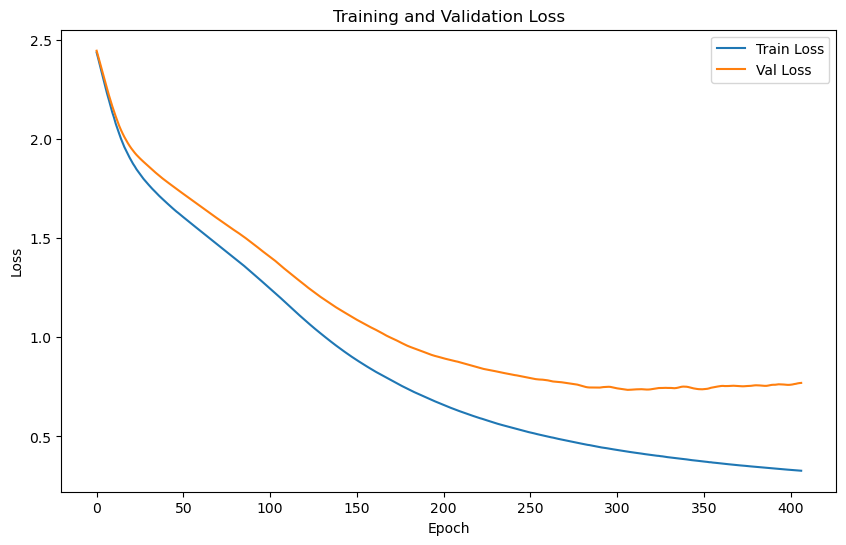

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.9695 | Test Accuracy: 59.64%


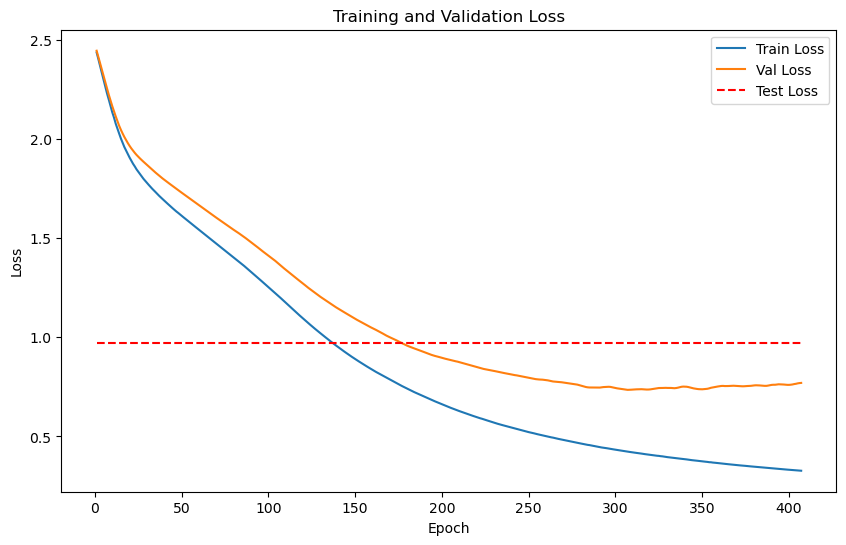

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4767
Epoch [1/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4767

Validation loss improved from inf to 0.4767. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4749
Epoch [2/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.4749

Validation loss improved from 0.4767 to 0.4749. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4728
Epoch [3/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.4728

Validation loss improved from 0.4749 to 0.4728. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4707
Epoch [4/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4707

Validation loss improved from 0.4728 to 0.4707. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4685
Epoch [5/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4685

Validation loss improved from 0.4707 to 0.4685. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.4662
Epoch [6/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4662

Validation loss improved from 0.4685 to 0.4662. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4635
Epoch [7/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.4635

Validation loss improved from 0.4662 to 0.4635. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.4614
Epoch [8/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4614

Validation loss improved from 0.4635 to 0.4614. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4598
Epoch [9/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4598

Validation loss improved from 0.4614 to 0.4598. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4584
Epoch [10/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.4584

Validation loss improved from 0.4598 to 0.4584. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4571
Epoch [11/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4571

Validation loss improved from 0.4584 to 0.4571. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [12/2000] - Validation


    Batch [1/1], Val Loss: 0.4556
Epoch [12/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4556

Validation loss improved from 0.4571 to 0.4556. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4539
Epoch [13/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4539

Validation loss improved from 0.4556 to 0.4539. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4523
Epoch [14/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4523

Validation loss improved from 0.4539 to 0.4523. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4504
Epoch [15/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.4504

Validation loss improved from 0.4523 to 0.4504. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4486
Epoch [16/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4486

Validation loss improved from 0.4504 to 0.4486. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4470
Epoch [17/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4470

Validation loss improved from 0.4486 to 0.4470. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4455
Epoch [18/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4455

Validation loss improved from 0.4470 to 0.4455. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4441
Epoch [19/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4441

Validation loss improved from 0.4455 to 0.4441. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4429


Epoch [20/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4429

Validation loss improved from 0.4441 to 0.4429. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4417
Epoch [21/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4417

Validation loss improved from 0.4429 to 0.4417. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.4406
Epoch [22/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4406

Validation loss improved from 0.4417 to 0.4406. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4395
Epoch [23/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4395

Validation loss improved from 0.4406 to 0.4395. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4386
Epoch [24/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4386

Validation loss improved from 0.4395 to 0.4386. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4378
Epoch [25/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.4378

Validation loss improved from 0.4386 to 0.4378. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4371
Epoch [26/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4371

Validation loss improved from 0.4378 to 0.4371. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4364
Epoch [27/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4364

Validation loss improved from 0.4371 to 0.4364. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4358
Epoch [28/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4358

Validation loss improved from 0.4364 to 0.4358. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.4352
Epoch [29/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4352

Validation loss improved from 0.4358 to 0.4352. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4347
Epoch [30/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4347

Validation loss improved from 0.4352 to 0.4347. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.4342
Epoch [31/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4342

Validation loss improved from 0.4347 to 0.4342. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4337
Epoch [32/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4337

Validation loss improved from 0.4342 to 0.4337. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4333
Epoch [33/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4333

Validation loss improved from 0.4337 to 0.4333. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4329
Epoch [34/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4329

Validation loss improved from 0.4333 to 0.4329. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4324
Epoch [35/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4324

Validation loss improved from 0.4329 to 0.4324. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [36/2000] - Validation


    Batch [1/1], Val Loss: 0.4320
Epoch [36/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4320

Validation loss improved from 0.4324 to 0.4320. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.4316
Epoch [37/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4316

Validation loss improved from 0.4320 to 0.4316. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4312
Epoch [38/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4312

Validation loss improved from 0.4316 to 0.4312. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4308
Epoch [39/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4308

Validation loss improved from 0.4312 to 0.4308. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4304
Epoch [40/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4304

Validation loss improved from 0.4308 to 0.4304. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4300
Epoch [41/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4300

Validation loss improved from 0.4304 to 0.4300. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4297
Epoch [42/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.4297

Validation loss improved from 0.4300 to 0.4297. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [43/2000] - Validation


    Batch [1/1], Val Loss: 0.4293
Epoch [43/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4293

Validation loss improved from 0.4297 to 0.4293. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.4290
Epoch [44/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4290

Validation loss improved from 0.4293 to 0.4290. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.4286
Epoch [45/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.4286

Validation loss improved from 0.4290 to 0.4286. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4282
Epoch [46/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.4282

Validation loss improved from 0.4286 to 0.4282. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4278
Epoch [47/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4278

Validation loss improved from 0.4282 to 0.4278. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.4275
Epoch [48/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.4275

Validation loss improved from 0.4278 to 0.4275. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.4271
Epoch [49/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.4271

Validation loss improved from 0.4275 to 0.4271. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.4268
Epoch [50/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.4268

Validation loss improved from 0.4271 to 0.4268. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.4264
Epoch [51/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.4264

Validation loss improved from 0.4268 to 0.4264. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4261
Epoch [52/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4261

Validation loss improved from 0.4264 to 0.4261. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4257
Epoch [53/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4257

Validation loss improved from 0.4261 to 0.4257. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4253
Epoch [54/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.4253

Validation loss improved from 0.4257 to 0.4253. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [55/2000] - Validation


    Batch [1/1], Val Loss: 0.4250
Epoch [55/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.4250

Validation loss improved from 0.4253 to 0.4250. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.4246
Epoch [56/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.4246

Validation loss improved from 0.4250 to 0.4246. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4243
Epoch [57/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.4243

Validation loss improved from 0.4246 to 0.4243. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.4239
Epoch [58/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.4239

Validation loss improved from 0.4243 to 0.4239. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.4235
Epoch [59/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.4235

Validation loss improved from 0.4239 to 0.4235. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.4232
Epoch [60/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.4232

Validation loss improved from 0.4235 to 0.4232. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.4228
Epoch [61/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.4228

Validation loss improved from 0.4232 to 0.4228. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [62/2000] - Validation


    Batch [1/1], Val Loss: 0.4224
Epoch [62/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.4224

Validation loss improved from 0.4228 to 0.4224. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4221
Epoch [63/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.4221

Validation loss improved from 0.4224 to 0.4221. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.4217
Epoch [64/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.4217

Validation loss improved from 0.4221 to 0.4217. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.4214
Epoch [65/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.4214

Validation loss improved from 0.4217 to 0.4214. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.4211
Epoch [66/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.4211

Validation loss improved from 0.4214 to 0.4211. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.4207
Epoch [67/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.4207

Validation loss improved from 0.4211 to 0.4207. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.4204
Epoch [68/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.4204

Validation loss improved from 0.4207 to 0.4204. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [69/2000] - Validation


    Batch [1/1], Val Loss: 0.4201
Epoch [69/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.4201

Validation loss improved from 0.4204 to 0.4201. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.4197
Epoch [70/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.4197

Validation loss improved from 0.4201 to 0.4197. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.4194
Epoch [71/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.4194

Validation loss improved from 0.4197 to 0.4194. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.4192
Epoch [72/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.4192

Validation loss improved from 0.4194 to 0.4192. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.4189
Epoch [73/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.4189

Validation loss improved from 0.4192 to 0.4189. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.4186
Epoch [74/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.4186

Validation loss improved from 0.4189 to 0.4186. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.4183
Epoch [75/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.4183

Validation loss improved from 0.4186 to 0.4183. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [76/2000] - Validation


    Batch [1/1], Val Loss: 0.4180
Epoch [76/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.4180

Validation loss improved from 0.4183 to 0.4180. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.4177
Epoch [77/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.4177

Validation loss improved from 0.4180 to 0.4177. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [78/2000] - Validation


    Batch [1/1], Val Loss: 0.4175
Epoch [78/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.4175

Validation loss improved from 0.4177 to 0.4175. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.4172
Epoch [79/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4172

Validation loss improved from 0.4175 to 0.4172. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [80/2000] - Validation


    Batch [1/1], Val Loss: 0.4169
Epoch [80/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.4169

Validation loss improved from 0.4172 to 0.4169. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.4166
Epoch [81/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.4166

Validation loss improved from 0.4169 to 0.4166. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [82/2000] - Validation


    Batch [1/1], Val Loss: 0.4163
Epoch [82/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.4163

Validation loss improved from 0.4166 to 0.4163. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.4160
Epoch [83/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.4160

Validation loss improved from 0.4163 to 0.4160. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.4158
Epoch [84/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.4158

Validation loss improved from 0.4160 to 0.4158. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.4155
Epoch [85/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.4155

Validation loss improved from 0.4158 to 0.4155. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.4153
Epoch [86/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.4153

Validation loss improved from 0.4155 to 0.4153. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.4150
Epoch [87/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.4150

Validation loss improved from 0.4153 to 0.4150. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.4148
Epoch [88/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.4148

Validation loss improved from 0.4150 to 0.4148. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.4146
Epoch [89/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.4146

Validation loss improved from 0.4148 to 0.4146. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.4144
Epoch [90/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.4144

Validation loss improved from 0.4146 to 0.4144. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.4142
Epoch [91/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.4142

Validation loss improved from 0.4144 to 0.4142. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.4140
Epoch [92/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.4140

Validation loss improved from 0.4142 to 0.4140. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.4139
Epoch [93/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.4139

Validation loss improved from 0.4140 to 0.4139. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.4137
Epoch [94/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.4137

Validation loss improved from 0.4139 to 0.4137. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.4135
Epoch [95/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.4135

Validation loss improved from 0.4137 to 0.4135. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.4134
Epoch [96/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.4134

Validation loss improved from 0.4135 to 0.4134. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.4132
Epoch [97/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.4132

Validation loss improved from 0.4134 to 0.4132. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.4130
Epoch [98/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.4130

Validation loss improved from 0.4132 to 0.4130. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.4128
Epoch [99/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.4128

Validation loss improved from 0.4130 to 0.4128. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [100/2000] - Validation


    Batch [1/1], Val Loss: 0.4126
Epoch [100/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.4126

Validation loss improved from 0.4128 to 0.4126. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.4124
Epoch [101/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.4124

Validation loss improved from 0.4126 to 0.4124. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [102/2000] - Validation


    Batch [1/1], Val Loss: 0.4123
Epoch [102/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.4123

Validation loss improved from 0.4124 to 0.4123. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.4121
Epoch [103/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.4121

Validation loss improved from 0.4123 to 0.4121. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.4120
Epoch [104/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.4120

Validation loss improved from 0.4121 to 0.4120. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.4118
Epoch [105/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.4118

Validation loss improved from 0.4120 to 0.4118. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.4116
Epoch [106/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.4116

Validation loss improved from 0.4118 to 0.4116. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [107/2000] - Validation


    Batch [1/1], Val Loss: 0.4114
Epoch [107/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.4114

Validation loss improved from 0.4116 to 0.4114. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.4113
Epoch [108/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.4113

Validation loss improved from 0.4114 to 0.4113. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.4111
Epoch [109/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.4111

Validation loss improved from 0.4113 to 0.4111. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.4110
Epoch [110/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.4110

Validation loss improved from 0.4111 to 0.4110. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [111/2000] - Validation


    Batch [1/1], Val Loss: 0.4108
Epoch [111/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.4108

Validation loss improved from 0.4110 to 0.4108. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.4107
Epoch [112/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.4107

Validation loss improved from 0.4108 to 0.4107. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.4106
Epoch [113/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.4106

Validation loss improved from 0.4107 to 0.4106. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.4104
Epoch [114/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.4104

Validation loss improved from 0.4106 to 0.4104. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.4103
Epoch [115/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.4103

Validation loss improved from 0.4104 to 0.4103. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.4101
Epoch [116/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.4101

Validation loss improved from 0.4103 to 0.4101. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.4100
Epoch [117/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.4100

Validation loss improved from 0.4101 to 0.4100. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.4098
Epoch [118/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.4098

Validation loss improved from 0.4100 to 0.4098. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.4097
Epoch [119/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.4097

Validation loss improved from 0.4098 to 0.4097. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.4096
Epoch [120/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.4096

Validation loss improved from 0.4097 to 0.4096. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.4094
Epoch [121/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.4094

Validation loss improved from 0.4096 to 0.4094. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [122/2000] - Validation


    Batch [1/1], Val Loss: 0.4093
Epoch [122/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.4093

Validation loss improved from 0.4094 to 0.4093. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.4091
Epoch [123/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.4091

Validation loss improved from 0.4093 to 0.4091. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.4090
Epoch [124/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.4090

Validation loss improved from 0.4091 to 0.4090. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.4089
Epoch [125/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.4089

Validation loss improved from 0.4090 to 0.4089. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.4089
Epoch [126/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.4089

Validation loss improved from 0.4089 to 0.4089. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.4088
Epoch [127/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.4088

Validation loss improved from 0.4089 to 0.4088. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.4087
Epoch [128/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.4087

Validation loss improved from 0.4088 to 0.4087. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.4086
Epoch [129/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.4086

Validation loss improved from 0.4087 to 0.4086. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.4086
Epoch [130/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.4086

Validation loss improved from 0.4086 to 0.4086. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [131/2000] - Validation


    Batch [1/1], Val Loss: 0.4085
Epoch [131/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.4085

Validation loss improved from 0.4086 to 0.4085. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.4085
Epoch [132/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.4085

Validation loss improved from 0.4085 to 0.4085. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [133/2000] - Validation


    Batch [1/1], Val Loss: 0.4084
Epoch [133/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.4084

Validation loss improved from 0.4085 to 0.4084. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.4083
Epoch [134/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.4083

Validation loss improved from 0.4084 to 0.4083. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.4082
Epoch [135/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.4082

Validation loss improved from 0.4083 to 0.4082. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.4082
Epoch [136/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.4082

Validation loss improved from 0.4082 to 0.4082. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.4081
Epoch [137/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.4081

Validation loss improved from 0.4082 to 0.4081. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.4080
Epoch [138/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.4080

Validation loss improved from 0.4081 to 0.4080. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.4079
Epoch [139/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.4079

Validation loss improved from 0.4080 to 0.4079. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [140/2000] - Validation


    Batch [1/1], Val Loss: 0.4078
Epoch [140/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.4078

Validation loss improved from 0.4079 to 0.4078. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.4078
Epoch [141/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.4078

Validation loss improved from 0.4078 to 0.4078. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.4077
Epoch [142/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.4077

Validation loss improved from 0.4078 to 0.4077. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.4076
Epoch [143/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.4076

Validation loss improved from 0.4077 to 0.4076. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.4075
Epoch [144/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.4075

Validation loss improved from 0.4076 to 0.4075. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [145/2000] - Validation


    Batch [1/1], Val Loss: 0.4074
Epoch [145/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.4074

Validation loss improved from 0.4075 to 0.4074. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.4073
Epoch [146/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.4073

Validation loss improved from 0.4074 to 0.4073. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.4072
Epoch [147/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.4072

Validation loss improved from 0.4073 to 0.4072. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.4071
Epoch [148/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.4071

Validation loss improved from 0.4072 to 0.4071. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.4071
Epoch [149/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.4071

Validation loss improved from 0.4071 to 0.4071. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.4070
Epoch [150/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.4070

Validation loss improved from 0.4071 to 0.4070. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.4069
Epoch [151/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.4069

Validation loss improved from 0.4070 to 0.4069. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [152/2000] - Validation


    Batch [1/1], Val Loss: 0.4069
Epoch [152/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.4069

Validation loss improved from 0.4069 to 0.4069. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.4069
Epoch [153/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.4069

Validation loss improved from 0.4069 to 0.4069. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [154/2000] - Validation


    Batch [1/1], Val Loss: 0.4068
Epoch [154/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.4068

Validation loss improved from 0.4069 to 0.4068. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.4068
Epoch [155/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.4068

Validation loss improved from 0.4068 to 0.4068. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.4068
Epoch [156/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.4068

Validation loss improved from 0.4068 to 0.4068. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.4067
Epoch [157/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.4067

Validation loss improved from 0.4068 to 0.4067. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.4067
Epoch [158/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.4067

Validation loss improved from 0.4067 to 0.4067. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [159/2000] - Validation


    Batch [1/1], Val Loss: 0.4067
Epoch [159/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.4067

Validation loss improved from 0.4067 to 0.4067. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.4066
Epoch [160/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.4066

Validation loss improved from 0.4067 to 0.4066. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [161/2000] - Validation


    Batch [1/1], Val Loss: 0.4066
Epoch [161/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.4066

Validation loss improved from 0.4066 to 0.4066. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [162/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.4065

Validation loss improved from 0.4066 to 0.4065. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [163/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.4065

Validation loss improved from 0.4065 to 0.4065. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [164/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.4065

Validation loss improved from 0.4065 to 0.4065. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [165/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.4065

Validation loss improved from 0.4065 to 0.4065. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [166/2000] - Validation


    Batch [1/1], Val Loss: 0.4065
Epoch [166/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.4065

Validation loss improved from 0.4065 to 0.4065. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [167/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.4065

Validation loss improved from 0.4065 to 0.4065. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [168/2000] - Validation


    Batch [1/1], Val Loss: 0.4065
Epoch [168/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.4065

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [169/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.4065

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [170/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.4065

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [171/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.4065

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.4066
Epoch [172/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.4066

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.4066
Epoch [173/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.4066

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [174/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.4065

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [175/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.4065

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.4065
Epoch [176/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.4065

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.4064
Epoch [177/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.4064

Validation loss improved from 0.4065 to 0.4064. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.4064
Epoch [178/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.4064

Validation loss improved from 0.4064 to 0.4064. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.4063
Epoch [179/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.4063

Validation loss improved from 0.4064 to 0.4063. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.4062
Epoch [180/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.4062

Validation loss improved from 0.4063 to 0.4062. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.4062
Epoch [181/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.4062

Validation loss improved from 0.4062 to 0.4062. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3520
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.4061
Epoch [182/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.4061

Validation loss improved from 0.4062 to 0.4061. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.4060
Epoch [183/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.4060

Validation loss improved from 0.4061 to 0.4060. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.4059
Epoch [184/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.4059

Validation loss improved from 0.4060 to 0.4059. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.4059
Epoch [185/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.4059

Validation loss improved from 0.4059 to 0.4059. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.4058
Epoch [186/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.4058

Validation loss improved from 0.4059 to 0.4058. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.4057
Epoch [187/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.4057

Validation loss improved from 0.4058 to 0.4057. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.4056
Epoch [188/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.4056

Validation loss improved from 0.4057 to 0.4056. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.4056
Epoch [189/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.4056

Validation loss improved from 0.4056 to 0.4056. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.4055
Epoch [190/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.4055

Validation loss improved from 0.4056 to 0.4055. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.4054
Epoch [191/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.4054

Validation loss improved from 0.4055 to 0.4054. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.4053
Epoch [192/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.4053

Validation loss improved from 0.4054 to 0.4053. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.4053
Epoch [193/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.4053

Validation loss improved from 0.4053 to 0.4053. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.4053
Epoch [194/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.4053

Validation loss improved from 0.4053 to 0.4053. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.4052
Epoch [195/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.4052

Validation loss improved from 0.4053 to 0.4052. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.4052
Epoch [196/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.4052

Validation loss improved from 0.4052 to 0.4052. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.4051
Epoch [197/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.4051

Validation loss improved from 0.4052 to 0.4051. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [198/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.4050

Validation loss improved from 0.4051 to 0.4050. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [199/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.4050

Validation loss improved from 0.4050 to 0.4050. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.4050
Epoch [200/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.4050

Validation loss improved from 0.4050 to 0.4050. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.4049
Epoch [201/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.4049

Validation loss improved from 0.4050 to 0.4049. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.4049
Epoch [202/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.4049

Validation loss improved from 0.4049 to 0.4049. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.4049
Epoch [203/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.4049

Validation loss improved from 0.4049 to 0.4049. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.4048
Epoch [204/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.4048

Validation loss improved from 0.4049 to 0.4048. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.4048
Epoch [205/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.4048

Validation loss improved from 0.4048 to 0.4048. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.4047
Epoch [206/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.4047

Validation loss improved from 0.4048 to 0.4047. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.4047
Epoch [207/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.4047

Validation loss improved from 0.4047 to 0.4047. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.4046
Epoch [208/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.4046

Validation loss improved from 0.4047 to 0.4046. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.4045
Epoch [209/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.4045

Validation loss improved from 0.4046 to 0.4045. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.4044
Epoch [210/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.4044

Validation loss improved from 0.4045 to 0.4044. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.4043
Epoch [211/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.4043

Validation loss improved from 0.4044 to 0.4043. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.4042
Epoch [212/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.4042

Validation loss improved from 0.4043 to 0.4042. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.4041
Epoch [213/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.4041

Validation loss improved from 0.4042 to 0.4041. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.4040
Epoch [214/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.4040

Validation loss improved from 0.4041 to 0.4040. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.4040
Epoch [215/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.4040

Validation loss improved from 0.4040 to 0.4040. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.4039
Epoch [216/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.4039

Validation loss improved from 0.4040 to 0.4039. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.4038
Epoch [217/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.4038

Validation loss improved from 0.4039 to 0.4038. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.4038
Epoch [218/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.4038

Validation loss improved from 0.4038 to 0.4038. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.4037
Epoch [219/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.4037

Validation loss improved from 0.4038 to 0.4037. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.4036
Epoch [220/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.4036

Validation loss improved from 0.4037 to 0.4036. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.4036
Epoch [221/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.4036

Validation loss improved from 0.4036 to 0.4036. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.4036
Epoch [222/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.4036

Validation loss improved from 0.4036 to 0.4036. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.4035
Epoch [223/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.4035

Validation loss improved from 0.4036 to 0.4035. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.4035
Epoch [224/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.4035

Validation loss improved from 0.4035 to 0.4035. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.4034
Epoch [225/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.4034

Validation loss improved from 0.4035 to 0.4034. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.4034
Epoch [226/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.4034

Validation loss improved from 0.4034 to 0.4034. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [227/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.4033

Validation loss improved from 0.4034 to 0.4033. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3353
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [228/2000], Avg Train Loss: 0.3353, Avg Val Loss: 0.4033

Validation loss improved from 0.4033 to 0.4033. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [229/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.4033

Validation loss improved from 0.4033 to 0.4033. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [230/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.4032

Validation loss improved from 0.4033 to 0.4032. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [231/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.4032

Validation loss improved from 0.4032 to 0.4032. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [232/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [233/2000] - Validation


    Batch [1/1], Val Loss: 0.4032
Epoch [233/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [234/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [235/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.4032

Validation loss improved from 0.4032 to 0.4032. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [236/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.4032

Validation loss improved from 0.4032 to 0.4032. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [237/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [238/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [239/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [240/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.4031

Validation loss improved from 0.4032 to 0.4031. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.4031
Epoch [241/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.4031

Validation loss improved from 0.4031 to 0.4031. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [242/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.4031

Validation loss improved from 0.4031 to 0.4031. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [243/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.4030

Validation loss improved from 0.4031 to 0.4030. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [244/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.4030

Validation loss improved from 0.4030 to 0.4030. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3356
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [245/2000], Avg Train Loss: 0.3356, Avg Val Loss: 0.4030

Validation loss improved from 0.4030 to 0.4030. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [246/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.4030

Validation loss improved from 0.4030 to 0.4030. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [247/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.4030

Validation loss improved from 0.4030 to 0.4030. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.4029
Epoch [248/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.4029

Validation loss improved from 0.4030 to 0.4029. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.4029
Epoch [249/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.4029

Validation loss improved from 0.4029 to 0.4029. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [250/2000] - Validation


    Batch [1/1], Val Loss: 0.4028
Epoch [250/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.4028

Validation loss improved from 0.4029 to 0.4028. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.4028
Epoch [251/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.4028

Validation loss improved from 0.4028 to 0.4028. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.4028
Epoch [252/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.4028

Validation loss improved from 0.4028 to 0.4028. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.4027
Epoch [253/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.4027

Validation loss improved from 0.4028 to 0.4027. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.4027
Epoch [254/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.4027

Validation loss improved from 0.4027 to 0.4027. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.4027
Epoch [255/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.4027

Validation loss improved from 0.4027 to 0.4027. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.4026
Epoch [256/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.4026

Validation loss improved from 0.4027 to 0.4026. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.4026
Epoch [257/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.4026

Validation loss improved from 0.4026 to 0.4026. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.4026
Epoch [258/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.4026

Validation loss improved from 0.4026 to 0.4026. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [259/2000] - Validation


    Batch [1/1], Val Loss: 0.4027
Epoch [259/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.4027

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.4027
Epoch [260/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.4027

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.4028
Epoch [261/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.4028

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.4028
Epoch [262/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.4028

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.4029
Epoch [263/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.4029

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [264/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [264/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [265/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [266/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [267/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [268/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [269/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.4033

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [270/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.4033

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.4034
Epoch [271/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.4034

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.4034
Epoch [272/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.4034

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [273/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.4033

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [274/2000] - Validation


    Batch [1/1], Val Loss: 0.4033
Epoch [274/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.4033

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [275/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.4033

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [276/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [277/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [278/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [279/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [280/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [281/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [282/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [283/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [284/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.3091
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [285/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [286/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [287/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [288/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [289/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [290/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [291/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.3151
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [292/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [293/2000] - Validation


    Batch [1/1], Val Loss: 0.4031
Epoch [293/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [294/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [295/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [296/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [297/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.4031
Epoch [298/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [299/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [300/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [301/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [302/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [303/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [304/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [305/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [306/2000] - Validation


    Batch [1/1], Val Loss: 0.4031
Epoch [306/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.3183
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [307/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [308/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [309/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [310/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [311/2000] - Validation


    Batch [1/1], Val Loss: 0.4031
Epoch [311/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [312/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [313/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [314/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [315/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [316/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [317/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [318/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [319/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [320/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [321/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [322/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [323/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [324/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [325/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [326/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [327/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [328/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [329/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [330/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [330/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [331/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [332/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [333/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [334/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [334/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [335/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [336/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [337/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [338/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [339/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [339/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [340/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [341/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [342/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [343/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [344/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [345/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [346/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [347/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [348/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [349/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [350/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [351/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [352/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [353/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [354/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [355/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3071
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [356/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [357/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [358/2000] - Validation


    Batch [1/1], Val Loss: 0.4030
Epoch [358/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.4030

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 358!!
No improvement for 100 epochs


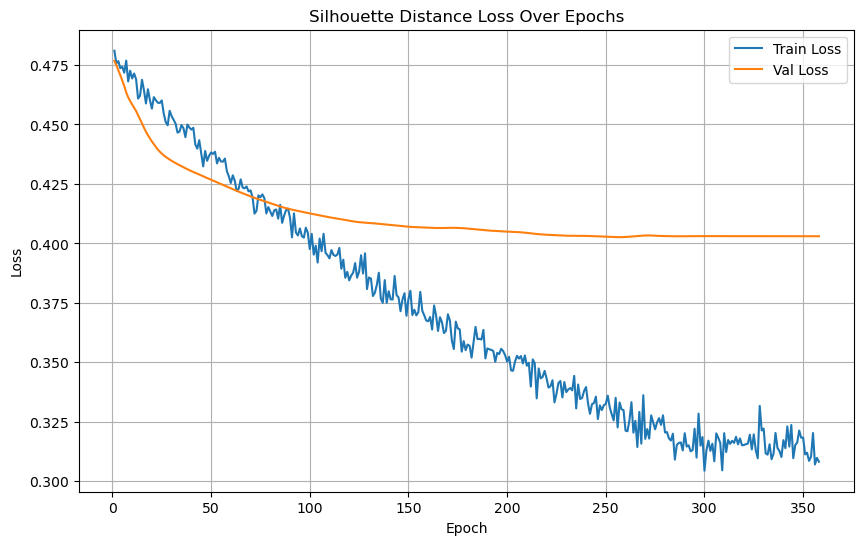

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.3178
Test Batch [20/667], Loss: 0.2105


Test Batch [30/667], Loss: 0.3009


Test Batch [40/667], Loss: 0.2693
Test Batch [50/667], Loss: 0.2360
Test Batch [60/667], Loss: 0.2403


Test Batch [70/667], Loss: 0.2218


Test Batch [80/667], Loss: 0.1900
Test Batch [90/667], Loss: 0.1115
Test Batch [100/667], Loss: 0.2159
Test Batch [110/667], Loss: 0.1547


Test Batch [120/667], Loss: 0.2398


Test Batch [130/667], Loss: 0.2827
Test Batch [140/667], Loss: 0.2244
Test Batch [150/667], Loss: 0.3062
Test Batch [160/667], Loss: 0.1770


Test Batch [170/667], Loss: 0.5000
Test Batch [180/667], Loss: 0.2111
Test Batch [190/667], Loss: 0.1756


Test Batch [200/667], Loss: 0.2108
Test Batch [210/667], Loss: 0.1888
Test Batch [220/667], Loss: 0.5000
Test Batch [230/667], Loss: 0.2055
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000


Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000
Test Batch [300/667], Loss: 0.5000


Test Batch [310/667], Loss: 0.3778
Test Batch [320/667], Loss: 0.2393
Test Batch [330/667], Loss: 0.2606


Test Batch [340/667], Loss: 0.2288


Test Batch [350/667], Loss: 0.2105
Test Batch [360/667], Loss: 0.2607


Test Batch [370/667], Loss: 0.2382


Test Batch [380/667], Loss: 0.2413
Test Batch [390/667], Loss: 0.1839


Test Batch [400/667], Loss: 0.1515


Test Batch [410/667], Loss: 0.2146
Test Batch [420/667], Loss: 0.2345


Test Batch [430/667], Loss: 0.1979


Test Batch [440/667], Loss: 0.3858
Test Batch [450/667], Loss: 0.2621
Test Batch [460/667], Loss: 0.4392


Test Batch [470/667], Loss: 0.3764
Test Batch [480/667], Loss: 0.3824
Test Batch [490/667], Loss: 0.3288


Test Batch [500/667], Loss: 0.3170
Test Batch [510/667], Loss: 0.1801
Test Batch [520/667], Loss: 0.3062


Test Batch [530/667], Loss: 0.3006
Test Batch [540/667], Loss: 0.2701
Test Batch [550/667], Loss: 0.3695


Test Batch [560/667], Loss: 0.2735
Test Batch [570/667], Loss: 0.2891
Test Batch [580/667], Loss: 0.2645
Test Batch [590/667], Loss: 0.2826


Test Batch [600/667], Loss: 0.3865
Test Batch [610/667], Loss: 0.3617
Test Batch [620/667], Loss: 0.4021
Test Batch [630/667], Loss: 0.3937
Test Batch [640/667], Loss: 0.2411


Test Batch [650/667], Loss: 0.4082
Test Batch [660/667], Loss: 0.4337

Test Loss: 0.3101


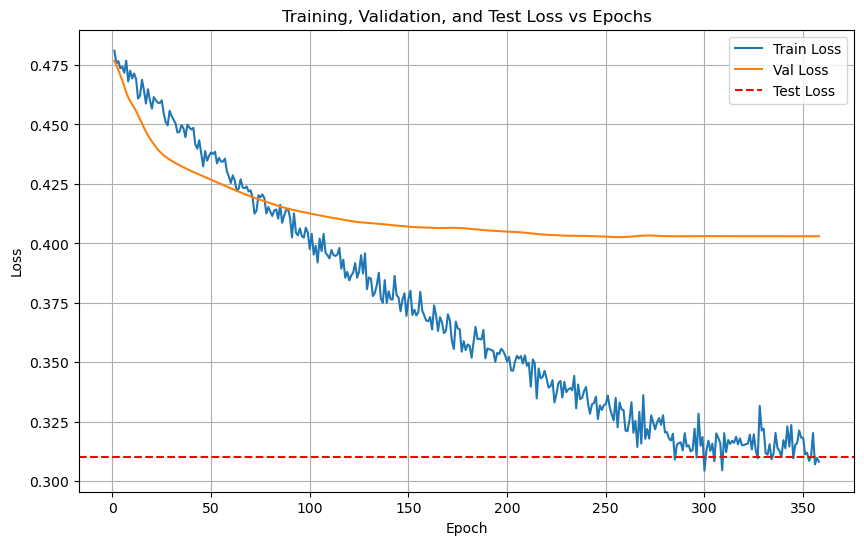

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/667 for test dataset.
  Processed batch 20/667 for test dataset.


  Processed batch 30/667 for test dataset.
  Processed batch 40/667 for test dataset.
  Processed batch 50/667 for test dataset.


  Processed batch 60/667 for test dataset.
  Processed batch 70/667 for test dataset.
  Processed batch 80/667 for test dataset.


  Processed batch 90/667 for test dataset.
  Processed batch 100/667 for test dataset.
  Processed batch 110/667 for test dataset.


  Processed batch 120/667 for test dataset.
  Processed batch 130/667 for test dataset.
  Processed batch 140/667 for test dataset.


  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.
  Processed batch 170/667 for test dataset.
  Processed batch 180/667 for test dataset.


  Processed batch 190/667 for test dataset.
  Processed batch 200/667 for test dataset.
  Processed batch 210/667 for test dataset.


  Processed batch 220/667 for test dataset.
  Processed batch 230/667 for test dataset.
  Processed batch 240/667 for test dataset.
  Processed batch 250/667 for test dataset.


  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.
  Processed batch 280/667 for test dataset.
  Processed batch 290/667 for test dataset.


  Processed batch 300/667 for test dataset.
  Processed batch 310/667 for test dataset.
  Processed batch 320/667 for test dataset.
  Processed batch 330/667 for test dataset.


  Processed batch 340/667 for test dataset.
  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.


  Processed batch 370/667 for test dataset.
  Processed batch 380/667 for test dataset.
  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.


  Processed batch 410/667 for test dataset.
  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.


  Processed batch 440/667 for test dataset.
  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.


  Processed batch 470/667 for test dataset.
  Processed batch 480/667 for test dataset.
  Processed batch 490/667 for test dataset.


  Processed batch 500/667 for test dataset.
  Processed batch 510/667 for test dataset.
  Processed batch 520/667 for test dataset.


  Processed batch 530/667 for test dataset.
  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.
  Processed batch 560/667 for test dataset.


  Processed batch 570/667 for test dataset.
  Processed batch 580/667 for test dataset.
  Processed batch 590/667 for test dataset.


  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.
  Processed batch 620/667 for test dataset.


  Processed batch 630/667 for test dataset.
  Processed batch 640/667 for test dataset.
  Processed batch 650/667 for test dataset.
  Processed batch 660/667 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.60      0.60      0.60         5
           2       0.50      0.40      0.44         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       0.60      0.60      0.60         5
           6       0.56      1.00      0.71         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5

    accuracy                           0.73        45
   macro avg       0.73      0.73      0.72        45
weighted avg       0.73      0.73      0.72        45


LOG: Evaluating on the test set...
Test Accuracy: 66.45%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4000  |  Val Loss: 2.3716
Validation loss improved from inf to 2.3716.
[Epoch 2/1000] Train Loss: 2.3587  |  Val Loss: 2.3409
Validation loss improved from 2.3716 to 2.3409.
[Epoch 3/1000] Train Loss: 2.3220  |  Val Loss: 2.3116
Validation loss improved from 2.3409 to 2.3116.
[Epoch 4/1000] Train Loss: 2.2907  |  Val Loss: 2.2848
Validation loss improved from 2.3116 to 2.2848.
[Epoch 5/1000] Train Loss: 2.2593  |  Val Loss: 2.2601
Validation loss improved from 2.2848 to 2.2601.
[Epoch 6/1000] Train Loss: 2.2290  |  Val Loss: 2.2371
Validation loss improved from 2.2601 to 2.2371.
[Epoch 7/1000] Train Loss: 2.2010  |  Val Loss: 2.2148
Validation loss improved from 2.2371 to 2.2148.
[Epoch 8/1000] Train Loss: 2.1724  |  Val Loss: 2.1930
Validation loss improved from 2.2148 to 2.1930.
[Epoch 9/1000] Train Loss: 2.1477  |  Val Loss: 2.1712
Validation loss improved from 2.1930 to 2.1712.
[Epoch 10/1000] Train Loss: 2.1208  |  Val Loss: 2.1502
Validation loss impr

[Epoch 36/1000] Train Loss: 1.6616  |  Val Loss: 1.7952
Validation loss improved from 1.8050 to 1.7952.
[Epoch 37/1000] Train Loss: 1.6483  |  Val Loss: 1.7855
Validation loss improved from 1.7952 to 1.7855.
[Epoch 38/1000] Train Loss: 1.6360  |  Val Loss: 1.7758
Validation loss improved from 1.7855 to 1.7758.
[Epoch 39/1000] Train Loss: 1.6239  |  Val Loss: 1.7662
Validation loss improved from 1.7758 to 1.7662.
[Epoch 40/1000] Train Loss: 1.6115  |  Val Loss: 1.7570
Validation loss improved from 1.7662 to 1.7570.
[Epoch 41/1000] Train Loss: 1.5993  |  Val Loss: 1.7479
Validation loss improved from 1.7570 to 1.7479.
[Epoch 42/1000] Train Loss: 1.5871  |  Val Loss: 1.7391
Validation loss improved from 1.7479 to 1.7391.
[Epoch 43/1000] Train Loss: 1.5754  |  Val Loss: 1.7304
Validation loss improved from 1.7391 to 1.7304.
[Epoch 44/1000] Train Loss: 1.5639  |  Val Loss: 1.7219
Validation loss improved from 1.7304 to 1.7219.
[Epoch 45/1000] Train Loss: 1.5522  |  Val Loss: 1.7136
Validati

[Epoch 46/1000] Train Loss: 1.5412  |  Val Loss: 1.7055
Validation loss improved from 1.7136 to 1.7055.
[Epoch 47/1000] Train Loss: 1.5298  |  Val Loss: 1.6976
Validation loss improved from 1.7055 to 1.6976.
[Epoch 48/1000] Train Loss: 1.5188  |  Val Loss: 1.6898
Validation loss improved from 1.6976 to 1.6898.
[Epoch 49/1000] Train Loss: 1.5083  |  Val Loss: 1.6821
Validation loss improved from 1.6898 to 1.6821.
[Epoch 50/1000] Train Loss: 1.4979  |  Val Loss: 1.6744
Validation loss improved from 1.6821 to 1.6744.
[Epoch 51/1000] Train Loss: 1.4876  |  Val Loss: 1.6668
Validation loss improved from 1.6744 to 1.6668.
[Epoch 52/1000] Train Loss: 1.4776  |  Val Loss: 1.6594
Validation loss improved from 1.6668 to 1.6594.
[Epoch 53/1000] Train Loss: 1.4673  |  Val Loss: 1.6521
Validation loss improved from 1.6594 to 1.6521.
[Epoch 54/1000] Train Loss: 1.4576  |  Val Loss: 1.6446
Validation loss improved from 1.6521 to 1.6446.
[Epoch 55/1000] Train Loss: 1.4479  |  Val Loss: 1.6373
Validati

[Epoch 82/1000] Train Loss: 1.2292  |  Val Loss: 1.4740
Validation loss improved from 1.4792 to 1.4740.
[Epoch 83/1000] Train Loss: 1.2219  |  Val Loss: 1.4689
Validation loss improved from 1.4740 to 1.4689.
[Epoch 84/1000] Train Loss: 1.2151  |  Val Loss: 1.4638
Validation loss improved from 1.4689 to 1.4638.
[Epoch 85/1000] Train Loss: 1.2083  |  Val Loss: 1.4588
Validation loss improved from 1.4638 to 1.4588.
[Epoch 86/1000] Train Loss: 1.2014  |  Val Loss: 1.4538
Validation loss improved from 1.4588 to 1.4538.
[Epoch 87/1000] Train Loss: 1.1946  |  Val Loss: 1.4489
Validation loss improved from 1.4538 to 1.4489.
[Epoch 88/1000] Train Loss: 1.1876  |  Val Loss: 1.4440
Validation loss improved from 1.4489 to 1.4440.
[Epoch 89/1000] Train Loss: 1.1811  |  Val Loss: 1.4392
Validation loss improved from 1.4440 to 1.4392.
[Epoch 90/1000] Train Loss: 1.1745  |  Val Loss: 1.4344
Validation loss improved from 1.4392 to 1.4344.


[Epoch 91/1000] Train Loss: 1.1677  |  Val Loss: 1.4297
Validation loss improved from 1.4344 to 1.4297.
[Epoch 92/1000] Train Loss: 1.1613  |  Val Loss: 1.4250
Validation loss improved from 1.4297 to 1.4250.
[Epoch 93/1000] Train Loss: 1.1547  |  Val Loss: 1.4203
Validation loss improved from 1.4250 to 1.4203.
[Epoch 94/1000] Train Loss: 1.1483  |  Val Loss: 1.4156
Validation loss improved from 1.4203 to 1.4156.
[Epoch 95/1000] Train Loss: 1.1418  |  Val Loss: 1.4110
Validation loss improved from 1.4156 to 1.4110.
[Epoch 96/1000] Train Loss: 1.1355  |  Val Loss: 1.4063
Validation loss improved from 1.4110 to 1.4063.
[Epoch 97/1000] Train Loss: 1.1290  |  Val Loss: 1.4017
Validation loss improved from 1.4063 to 1.4017.
[Epoch 98/1000] Train Loss: 1.1229  |  Val Loss: 1.3971
Validation loss improved from 1.4017 to 1.3971.
[Epoch 99/1000] Train Loss: 1.1165  |  Val Loss: 1.3925
Validation loss improved from 1.3971 to 1.3925.
[Epoch 100/1000] Train Loss: 1.1102  |  Val Loss: 1.3879
Validat

[Epoch 129/1000] Train Loss: 0.9383  |  Val Loss: 1.2681
Validation loss improved from 1.2718 to 1.2681.
[Epoch 130/1000] Train Loss: 0.9323  |  Val Loss: 1.2643
Validation loss improved from 1.2681 to 1.2643.
[Epoch 131/1000] Train Loss: 0.9271  |  Val Loss: 1.2606
Validation loss improved from 1.2643 to 1.2606.
[Epoch 132/1000] Train Loss: 0.9216  |  Val Loss: 1.2568
Validation loss improved from 1.2606 to 1.2568.
[Epoch 133/1000] Train Loss: 0.9161  |  Val Loss: 1.2531
Validation loss improved from 1.2568 to 1.2531.
[Epoch 134/1000] Train Loss: 0.9107  |  Val Loss: 1.2495
Validation loss improved from 1.2531 to 1.2495.
[Epoch 135/1000] Train Loss: 0.9054  |  Val Loss: 1.2460
Validation loss improved from 1.2495 to 1.2460.
[Epoch 136/1000] Train Loss: 0.9000  |  Val Loss: 1.2424
Validation loss improved from 1.2460 to 1.2424.
[Epoch 137/1000] Train Loss: 0.8947  |  Val Loss: 1.2389
Validation loss improved from 1.2424 to 1.2389.
[Epoch 138/1000] Train Loss: 0.8894  |  Val Loss: 1.235

[Epoch 139/1000] Train Loss: 0.8843  |  Val Loss: 1.2319
Validation loss improved from 1.2354 to 1.2319.
[Epoch 140/1000] Train Loss: 0.8790  |  Val Loss: 1.2285
Validation loss improved from 1.2319 to 1.2285.
[Epoch 141/1000] Train Loss: 0.8737  |  Val Loss: 1.2251
Validation loss improved from 1.2285 to 1.2251.
[Epoch 142/1000] Train Loss: 0.8688  |  Val Loss: 1.2216
Validation loss improved from 1.2251 to 1.2216.
[Epoch 143/1000] Train Loss: 0.8636  |  Val Loss: 1.2183
Validation loss improved from 1.2216 to 1.2183.
[Epoch 144/1000] Train Loss: 0.8585  |  Val Loss: 1.2150
Validation loss improved from 1.2183 to 1.2150.
[Epoch 145/1000] Train Loss: 0.8534  |  Val Loss: 1.2118
Validation loss improved from 1.2150 to 1.2118.
[Epoch 146/1000] Train Loss: 0.8484  |  Val Loss: 1.2086
Validation loss improved from 1.2118 to 1.2086.
[Epoch 147/1000] Train Loss: 0.8436  |  Val Loss: 1.2055
Validation loss improved from 1.2086 to 1.2055.
[Epoch 148/1000] Train Loss: 0.8384  |  Val Loss: 1.202

[Epoch 176/1000] Train Loss: 0.7030  |  Val Loss: 1.1229
Validation loss improved from 1.1256 to 1.1229.
[Epoch 177/1000] Train Loss: 0.6984  |  Val Loss: 1.1201
Validation loss improved from 1.1229 to 1.1201.
[Epoch 178/1000] Train Loss: 0.6938  |  Val Loss: 1.1175
Validation loss improved from 1.1201 to 1.1175.
[Epoch 179/1000] Train Loss: 0.6892  |  Val Loss: 1.1149
Validation loss improved from 1.1175 to 1.1149.
[Epoch 180/1000] Train Loss: 0.6851  |  Val Loss: 1.1125
Validation loss improved from 1.1149 to 1.1125.
[Epoch 181/1000] Train Loss: 0.6803  |  Val Loss: 1.1100
Validation loss improved from 1.1125 to 1.1100.
[Epoch 182/1000] Train Loss: 0.6763  |  Val Loss: 1.1073
Validation loss improved from 1.1100 to 1.1073.
[Epoch 183/1000] Train Loss: 0.6716  |  Val Loss: 1.1047
Validation loss improved from 1.1073 to 1.1047.
[Epoch 184/1000] Train Loss: 0.6673  |  Val Loss: 1.1021
Validation loss improved from 1.1047 to 1.1021.


[Epoch 185/1000] Train Loss: 0.6630  |  Val Loss: 1.0995
Validation loss improved from 1.1021 to 1.0995.
[Epoch 186/1000] Train Loss: 0.6587  |  Val Loss: 1.0969
Validation loss improved from 1.0995 to 1.0969.
[Epoch 187/1000] Train Loss: 0.6541  |  Val Loss: 1.0944
Validation loss improved from 1.0969 to 1.0944.
[Epoch 188/1000] Train Loss: 0.6498  |  Val Loss: 1.0919
Validation loss improved from 1.0944 to 1.0919.
[Epoch 189/1000] Train Loss: 0.6457  |  Val Loss: 1.0894
Validation loss improved from 1.0919 to 1.0894.
[Epoch 190/1000] Train Loss: 0.6412  |  Val Loss: 1.0869
Validation loss improved from 1.0894 to 1.0869.
[Epoch 191/1000] Train Loss: 0.6369  |  Val Loss: 1.0841
Validation loss improved from 1.0869 to 1.0841.
[Epoch 192/1000] Train Loss: 0.6327  |  Val Loss: 1.0815
Validation loss improved from 1.0841 to 1.0815.
[Epoch 193/1000] Train Loss: 0.6287  |  Val Loss: 1.0789
Validation loss improved from 1.0815 to 1.0789.
[Epoch 194/1000] Train Loss: 0.6244  |  Val Loss: 1.076

[Epoch 218/1000] Train Loss: 0.5334  |  Val Loss: 1.0169
Validation loss improved from 1.0190 to 1.0169.
[Epoch 219/1000] Train Loss: 0.5301  |  Val Loss: 1.0148
Validation loss improved from 1.0169 to 1.0148.
[Epoch 220/1000] Train Loss: 0.5267  |  Val Loss: 1.0129
Validation loss improved from 1.0148 to 1.0129.
[Epoch 221/1000] Train Loss: 0.5233  |  Val Loss: 1.0112
Validation loss improved from 1.0129 to 1.0112.
[Epoch 222/1000] Train Loss: 0.5200  |  Val Loss: 1.0095
Validation loss improved from 1.0112 to 1.0095.
[Epoch 223/1000] Train Loss: 0.5165  |  Val Loss: 1.0078
Validation loss improved from 1.0095 to 1.0078.
[Epoch 224/1000] Train Loss: 0.5133  |  Val Loss: 1.0059
Validation loss improved from 1.0078 to 1.0059.
[Epoch 225/1000] Train Loss: 0.5101  |  Val Loss: 1.0040
Validation loss improved from 1.0059 to 1.0040.
[Epoch 226/1000] Train Loss: 0.5067  |  Val Loss: 1.0023
Validation loss improved from 1.0040 to 1.0023.
[Epoch 227/1000] Train Loss: 0.5035  |  Val Loss: 1.000

[Epoch 228/1000] Train Loss: 0.5004  |  Val Loss: 0.9990
Validation loss improved from 1.0006 to 0.9990.
[Epoch 229/1000] Train Loss: 0.4972  |  Val Loss: 0.9976
Validation loss improved from 0.9990 to 0.9976.
[Epoch 230/1000] Train Loss: 0.4940  |  Val Loss: 0.9962
Validation loss improved from 0.9976 to 0.9962.
[Epoch 231/1000] Train Loss: 0.4911  |  Val Loss: 0.9946
Validation loss improved from 0.9962 to 0.9946.
[Epoch 232/1000] Train Loss: 0.4879  |  Val Loss: 0.9930
Validation loss improved from 0.9946 to 0.9930.
[Epoch 233/1000] Train Loss: 0.4847  |  Val Loss: 0.9914
Validation loss improved from 0.9930 to 0.9914.
[Epoch 234/1000] Train Loss: 0.4819  |  Val Loss: 0.9899
Validation loss improved from 0.9914 to 0.9899.
[Epoch 235/1000] Train Loss: 0.4787  |  Val Loss: 0.9883
Validation loss improved from 0.9899 to 0.9883.
[Epoch 236/1000] Train Loss: 0.4757  |  Val Loss: 0.9868
Validation loss improved from 0.9883 to 0.9868.
[Epoch 237/1000] Train Loss: 0.4729  |  Val Loss: 0.985

[Epoch 269/1000] Train Loss: 0.3890  |  Val Loss: 0.9445
Validation loss improved from 0.9457 to 0.9445.
[Epoch 270/1000] Train Loss: 0.3866  |  Val Loss: 0.9434
Validation loss improved from 0.9445 to 0.9434.
[Epoch 271/1000] Train Loss: 0.3844  |  Val Loss: 0.9423
Validation loss improved from 0.9434 to 0.9423.
[Epoch 272/1000] Train Loss: 0.3822  |  Val Loss: 0.9411
Validation loss improved from 0.9423 to 0.9411.
[Epoch 273/1000] Train Loss: 0.3798  |  Val Loss: 0.9399
Validation loss improved from 0.9411 to 0.9399.
[Epoch 274/1000] Train Loss: 0.3775  |  Val Loss: 0.9387
Validation loss improved from 0.9399 to 0.9387.
[Epoch 275/1000] Train Loss: 0.3753  |  Val Loss: 0.9375
Validation loss improved from 0.9387 to 0.9375.
[Epoch 276/1000] Train Loss: 0.3730  |  Val Loss: 0.9362
Validation loss improved from 0.9375 to 0.9362.
[Epoch 277/1000] Train Loss: 0.3707  |  Val Loss: 0.9350
Validation loss improved from 0.9362 to 0.9350.
[Epoch 278/1000] Train Loss: 0.3685  |  Val Loss: 0.933

[Epoch 314/1000] Train Loss: 0.2978  |  Val Loss: 0.9025
Validation loss improved from 0.9032 to 0.9025.
[Epoch 315/1000] Train Loss: 0.2959  |  Val Loss: 0.9021
Validation loss improved from 0.9025 to 0.9021.
[Epoch 316/1000] Train Loss: 0.2942  |  Val Loss: 0.9016
Validation loss improved from 0.9021 to 0.9016.
[Epoch 317/1000] Train Loss: 0.2924  |  Val Loss: 0.9015
Validation loss improved from 0.9016 to 0.9015.
[Epoch 318/1000] Train Loss: 0.2908  |  Val Loss: 0.9013
Validation loss improved from 0.9015 to 0.9013.
[Epoch 319/1000] Train Loss: 0.2889  |  Val Loss: 0.9011
Validation loss improved from 0.9013 to 0.9011.
[Epoch 320/1000] Train Loss: 0.2872  |  Val Loss: 0.9008
Validation loss improved from 0.9011 to 0.9008.
[Epoch 321/1000] Train Loss: 0.2855  |  Val Loss: 0.9006
Validation loss improved from 0.9008 to 0.9006.
[Epoch 322/1000] Train Loss: 0.2838  |  Val Loss: 0.9000
Validation loss improved from 0.9006 to 0.9000.
[Epoch 323/1000] Train Loss: 0.2821  |  Val Loss: 0.899

[Epoch 359/1000] Train Loss: 0.2283  |  Val Loss: 0.8925
Validation loss improved from 0.8932 to 0.8925.
[Epoch 360/1000] Train Loss: 0.2271  |  Val Loss: 0.8919
Validation loss improved from 0.8925 to 0.8919.
[Epoch 361/1000] Train Loss: 0.2257  |  Val Loss: 0.8917
Validation loss improved from 0.8919 to 0.8917.
[Epoch 362/1000] Train Loss: 0.2245  |  Val Loss: 0.8918
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 363/1000] Train Loss: 0.2233  |  Val Loss: 0.8918
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 364/1000] Train Loss: 0.2219  |  Val Loss: 0.8921
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 365/1000] Train Loss: 0.2208  |  Val Loss: 0.8927
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 366/1000] Train Loss: 0.2195  |  Val Loss: 0.8936
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 367/1000] Train Loss: 0.2182  |  Val Loss: 0.8941
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 368/1000] Tr

[Epoch 402/1000] Train Loss: 0.1805  |  Val Loss: 0.8947
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 403/1000] Train Loss: 0.1795  |  Val Loss: 0.8945
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 404/1000] Train Loss: 0.1785  |  Val Loss: 0.8939
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 405/1000] Train Loss: 0.1777  |  Val Loss: 0.8929
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 406/1000] Train Loss: 0.1768  |  Val Loss: 0.8920
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 407/1000] Train Loss: 0.1759  |  Val Loss: 0.8914
Validation loss improved from 0.8917 to 0.8914.
[Epoch 408/1000] Train Loss: 0.1751  |  Val Loss: 0.8912
Validation loss improved from 0.8914 to 0.8912.
[Epoch 409/1000] Train Loss: 0.1743  |  Val Loss: 0.8912
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 410/1000] Train Loss: 0.1734  |  Val Loss: 0.8915
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 4

[Epoch 444/1000] Train Loss: 0.1483  |  Val Loss: 0.9065
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 445/1000] Train Loss: 0.1476  |  Val Loss: 0.9067
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 446/1000] Train Loss: 0.1469  |  Val Loss: 0.9070
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 447/1000] Train Loss: 0.1464  |  Val Loss: 0.9074
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 448/1000] Train Loss: 0.1457  |  Val Loss: 0.9078
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 449/1000] Train Loss: 0.1451  |  Val Loss: 0.9084
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 450/1000] Train Loss: 0.1444  |  Val Loss: 0.9092
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 451/1000] Train Loss: 0.1438  |  Val Loss: 0.9104
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 452/1000] Train Loss: 0.1431  |  Val Loss: 0.9112
!! Validation loss did NOT improve !! Patience:

[Epoch 489/1000] Train Loss: 0.1232  |  Val Loss: 0.9360
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 490/1000] Train Loss: 0.1227  |  Val Loss: 0.9366
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 491/1000] Train Loss: 0.1222  |  Val Loss: 0.9371
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 492/1000] Train Loss: 0.1217  |  Val Loss: 0.9375
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 493/1000] Train Loss: 0.1213  |  Val Loss: 0.9381
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 494/1000] Train Loss: 0.1207  |  Val Loss: 0.9390
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 495/1000] Train Loss: 0.1203  |  Val Loss: 0.9396
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 496/1000] Train Loss: 0.1198  |  Val Loss: 0.9403
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 497/1000] Train Loss: 0.1194  |  Val Loss: 0.9413
!! Validation loss did NOT improve !! Patience:

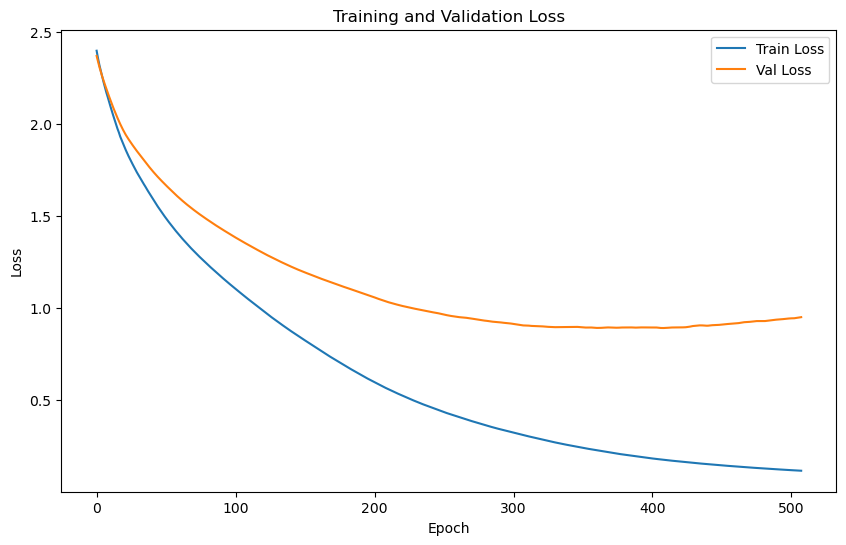

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.2889 | Test Accuracy: 67.30%


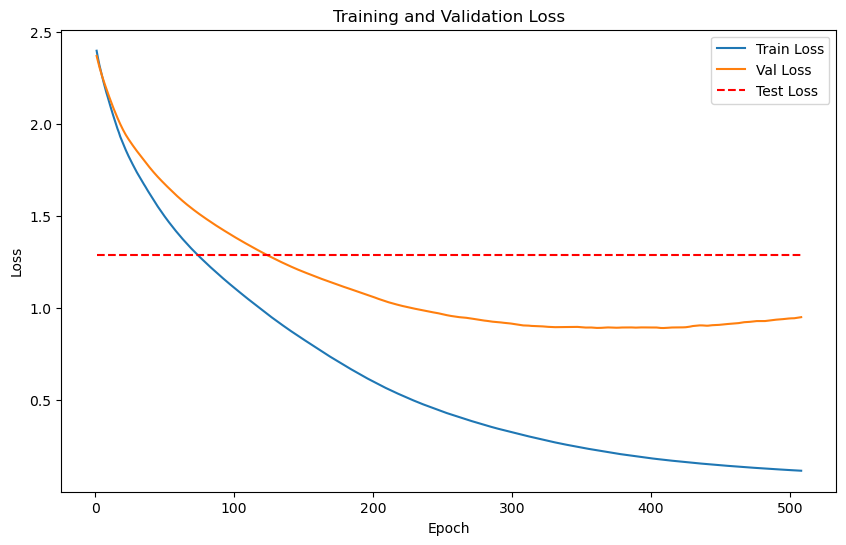

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


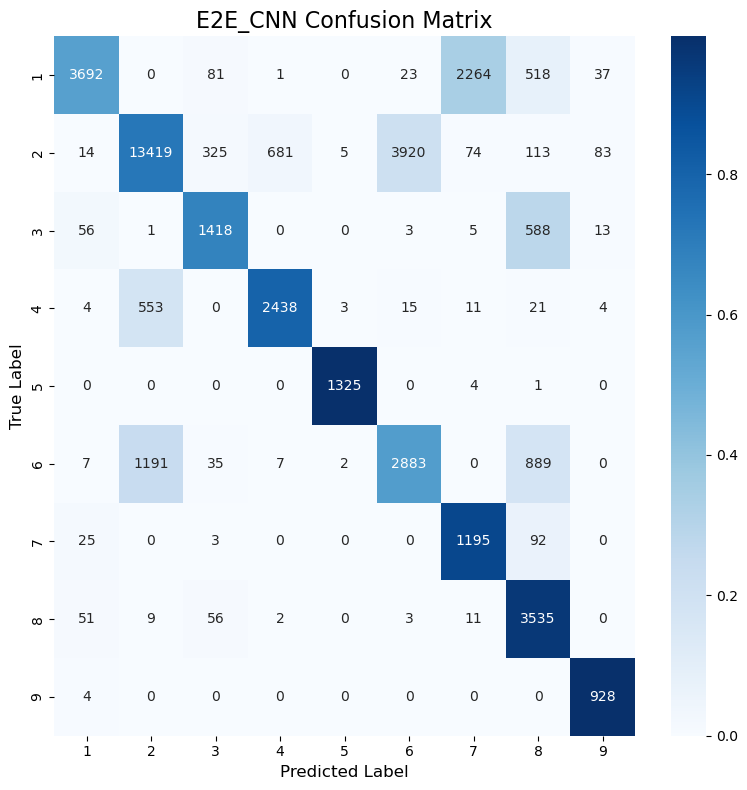

Classification Accuracy: 72.31%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


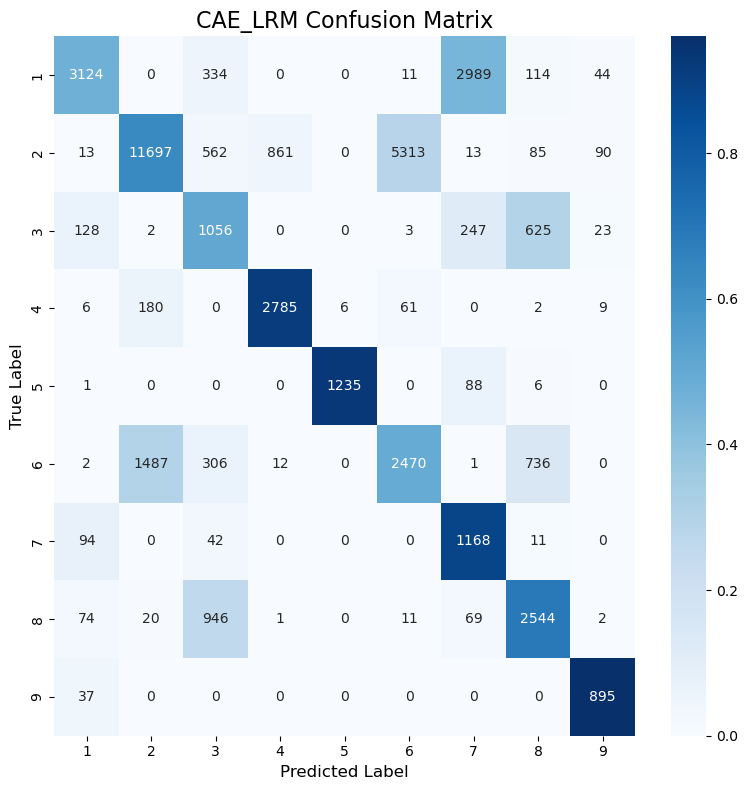

Classification Accuracy: 63.26%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


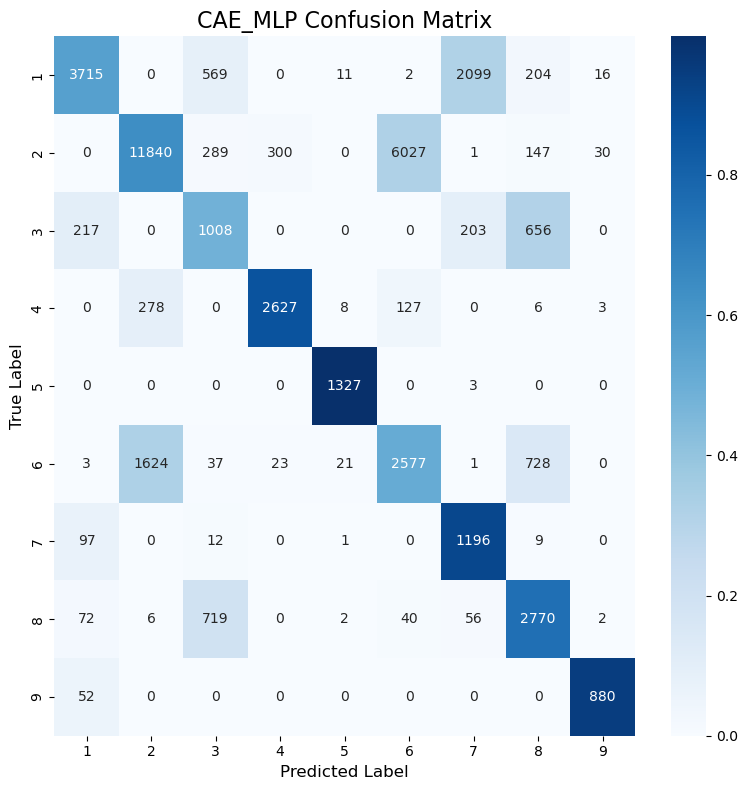

Classification Accuracy: 65.52%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


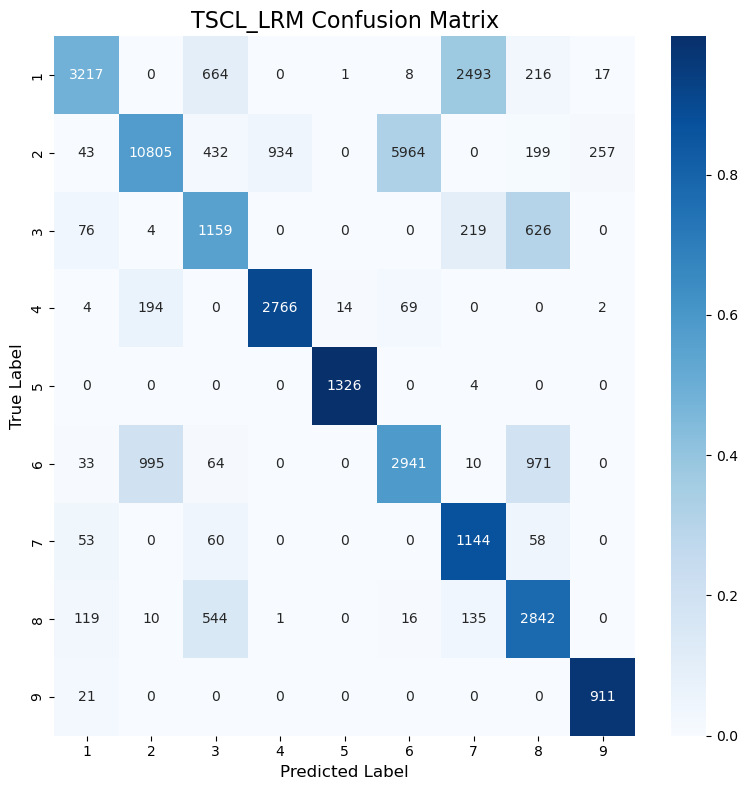

Classification Accuracy: 63.58%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


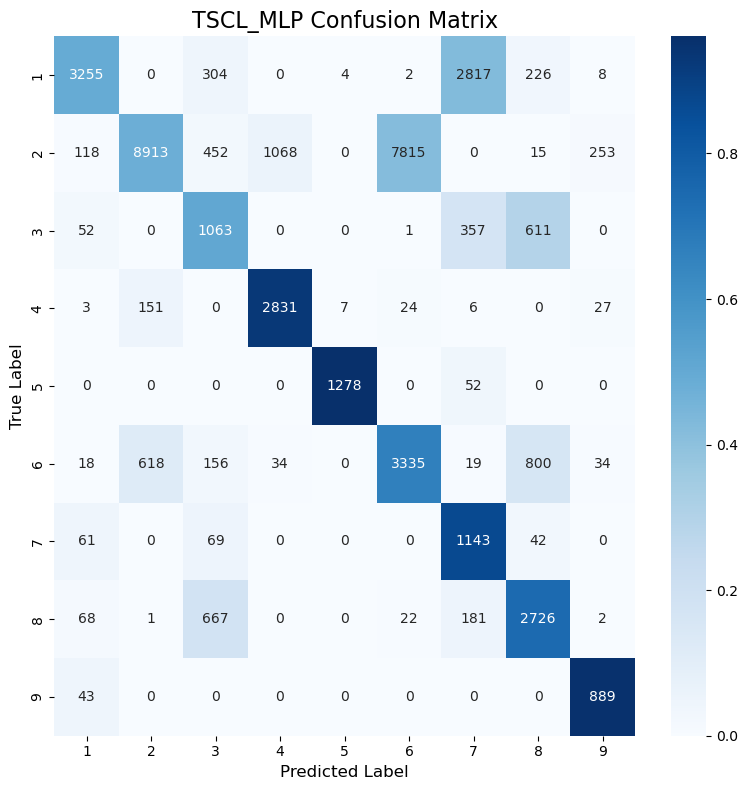

Classification Accuracy: 59.64%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


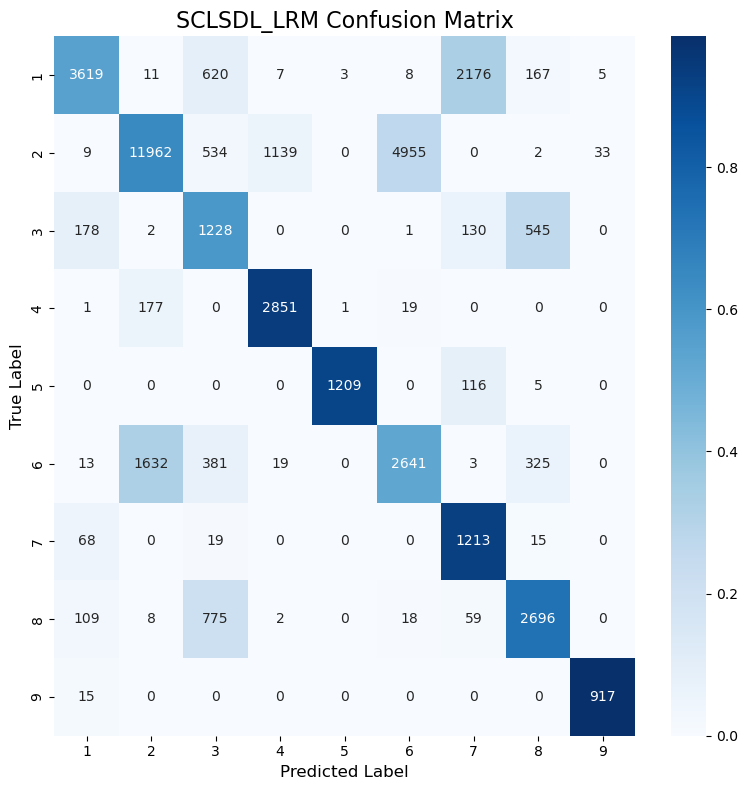

Classification Accuracy: 66.45%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


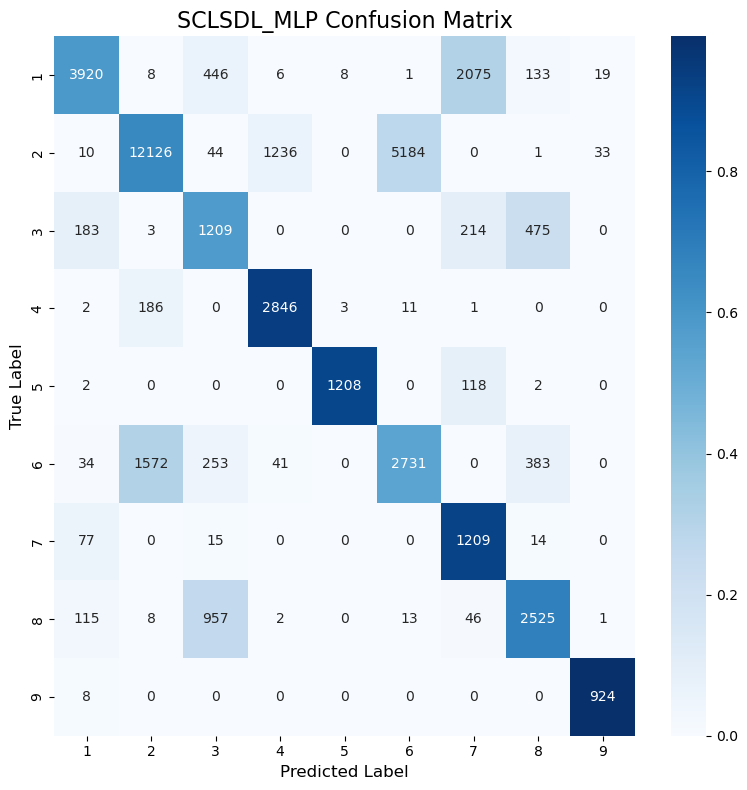

Classification Accuracy: 67.30%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          72.31
1    LRM (CAE)          63.26
2    MLP (CAE)          65.52
3     TSCL LRM          63.58
4     TSCL MLP          59.64
5  SCL_SDL LRM          66.45
6  SCL_SDL MLP          67.30

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          72.31
6  SCL_SDL MLP          67.30
5  SCL_SDL LRM          66.45
2    MLP (CAE)          65.52
3     TSCL LRM          63.58
1    LRM (CAE)          63.26
4     TSCL MLP          59.64
